# Datawarehouse e Análise OLAP para Dados do E-Commerce: Olist
// Arturo Kolster Borges // kolster.arturo@gmail.com //



## Carregar Dados

In [1]:
import pandas as pd
import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
# ---  E-Commerce Dataset --- #

# Descargar e obter o path
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

# Carregar todos os arquivos em DataFrames
customers = pd.read_csv(os.path.join(path, "olist_customers_dataset.csv"))
geolocation = pd.read_csv(os.path.join(path, "olist_geolocation_dataset.csv"))
order_items = pd.read_csv(os.path.join(path, "olist_order_items_dataset.csv"))
order_payments = pd.read_csv(os.path.join(path, "olist_order_payments_dataset.csv"))
order_reviews = pd.read_csv(os.path.join(path, "olist_order_reviews_dataset.csv"))
orders = pd.read_csv(os.path.join(path, "olist_orders_dataset.csv"))
products = pd.read_csv(os.path.join(path, "olist_products_dataset.csv"))
sellers = pd.read_csv(os.path.join(path, "olist_sellers_dataset.csv"))
category_translation = pd.read_csv(os.path.join(path, "product_category_name_translation.csv"))

# Print Dataframes
print("Customers:", customers.shape)
print("Orders:", orders.shape)
print("Products:", products.shape)
print(customers.head())



Customers: (99441, 5)
Orders: (99441, 8)
Products: (32951, 9)
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  


In [3]:
# --- Marketing Funnel Dataset --- #

# Descargar e obter o path
path_leads = kagglehub.dataset_download("olistbr/marketing-funnel-olist")

# Carregar os arquivos em DataFrames
closed_deals = pd.read_csv(os.path.join(path_leads, "olist_closed_deals_dataset.csv"))
mql = pd.read_csv(os.path.join(path_leads, "olist_marketing_qualified_leads_dataset.csv"))

print("Closed Deals:", closed_deals.shape)
print("Marketing Qualified Leads:", mql.shape)

print(closed_deals.head())
print(mql.head())


100%|██████████| 278k/278k [00:00<00:00, 76.0MB/s]

Extracting files...
Closed Deals: (842, 14)
Marketing Qualified Leads: (8000, 4)
                             mql_id                         seller_id  \
0  5420aad7fec3549a85876ba1c529bd84  2c43fb513632d29b3b58df74816f1b06   
1  a555fb36b9368110ede0f043dfc3b9a0  bbb7d7893a450660432ea6652310ebb7   
2  327174d3648a2d047e8940d7d15204ca  612170e34b97004b3ba37eae81836b4c   
3  f5fee8f7da74f4887f5bcae2bafb6dd6  21e1781e36faf92725dde4730a88ca0f   
4  ffe640179b554e295c167a2f6be528e0  ed8cb7b190ceb6067227478e48cf8dde   

                             sdr_id                             sr_id  \
0  a8387c01a09e99ce014107505b92388c  4ef15afb4b2723d8f3d81e51ec7afefe   
1  09285259593c61296eef10c734121d5b  d3d1e91a157ea7f90548eef82f1955e3   
2  b90f87164b5f8c2cfa5c8572834dbe3f  6565aa9ce3178a5caf6171827af3a9ba   
3  56bf83c4bb35763a51c2baab501b4c67  d3d1e91a157ea7f90548eef82f1955e3   
4  4b339f9567d060bcea4f5136b9f5949e  d3d1e91a157ea7f90548eef82f1955e3   

              won_date business_segment  

## Fact Table Creation

### Sales Perfomace (Star Schema)

In [4]:
# === 1. Dimensão Date ===
all_dates = pd.concat([
    orders['order_purchase_timestamp'],
    order_reviews['review_creation_date'],
    orders['order_delivered_customer_date'],
    mql['first_contact_date'],
], axis=0)

dim_date = pd.DataFrame({'order_date': pd.to_datetime(all_dates.dropna().unique(), format='mixed')})
dim_date['date_id'] = dim_date['order_date'].dt.strftime('%Y%m%d').astype(int)
dim_date['day'] = dim_date['order_date'].dt.day
dim_date['month'] = dim_date['order_date'].dt.month
dim_date['quarter'] = dim_date['order_date'].dt.quarter
dim_date['year'] = dim_date['order_date'].dt.year

# Reordenar columnas
dim_date = dim_date[['date_id', 'order_date', 'day', 'month', 'quarter', 'year']]



In [5]:
# === 2. Dimensão Cliente ===
dim_customer = customers[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']].drop_duplicates()

In [6]:
# === 3. Dimensão Producto ===
dim_product = products.merge(category_translation, on='product_category_name', how='left')
dim_product = dim_product[['product_id', 'product_category_name_english']].drop_duplicates()
dim_product.rename(columns={'product_category_name_english': 'product_category_name'}, inplace=True)


In [7]:
# === 4. Dimensão Vendedor ===
dim_seller = sellers[['seller_id', 'seller_city', 'seller_state']].drop_duplicates()

In [8]:
# === 5. Fact Table ===

# Merge com Order
fct_sales = order_items.merge(orders[['order_id', 'order_purchase_timestamp', 'customer_id']], on='order_id', how='left')

# Payment_value total por order_id
payment_summary = order_payments.groupby('order_id')['payment_value'].sum().reset_index()
fct_sales = fct_sales.merge(payment_summary, on='order_id', how='left')

# Obter date_id desde dim_date
fct_sales['order_purchase_timestamp'] = pd.to_datetime(fct_sales['order_purchase_timestamp'])
fct_sales = fct_sales.merge(dim_date[['date_id', 'order_date']], left_on='order_purchase_timestamp', right_on='order_date', how='left')

# Agregar medidas
fct_sales['order_amount'] = fct_sales['price']
fct_sales['quantity'] = 1

# Seleccionar columnas finais
fct_sales = fct_sales[[
    'order_id',
    'order_item_id',
    'product_id',
    'seller_id',
    'customer_id',
    'date_id',
    'order_amount',
    'quantity',
    'payment_value'
]]

In [9]:
fct_sales.head()

,order_id,order_item_id,product_id,seller_id,customer_id,date_id,order_amount,quantity,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,3ce436f183e68e07877b285a838db11a,20170913,58.90,1,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,f6dd3ec061db4e3987629fe6b26e5cce,20170426,239.90,1,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,6489ae5e4333f3693df5ad4372dab6d3,20180114,199.00,1,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,d4eb9395c8c0431ee92fce09860c5a06,20180808,12.99,1,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,58dbd0b2d70206bf40e62cd34e84d795,20170204,199.90,1,218.04


In [10]:
fct_sales.describe()

,order_item_id,date_id,order_amount,quantity,payment_value
count,112651.000000,1.126510e+05,112651.000000,112651.0,112648.000000
mean,1.197832,2.017604e+07,120.652922,1.0,180.279950
std,0.705121,4.875966e+03,183.633318,0.0,272.848146
min,1.000000,2.016090e+07,0.850000,1.0,9.590000
25%,1.000000,2.017091e+07,39.900000,1.0,65.670000
50%,1.000000,2.018012e+07,74.990000,1.0,114.440000
75%,1.000000,2.018050e+07,134.900000,1.0,195.390000
max,21.000000,2.018090e+07,6735.000000,1.0,13664.080000


### Marketing Funnel (StarSchema)

#### Dimensões

In [11]:
mql['first_contact_date'] = pd.to_datetime(mql['first_contact_date'], errors='coerce')
closed_deals['won_date'] = pd.to_datetime(closed_deals['won_date'], errors='coerce')

In [12]:
print(mql.columns.tolist())


['mql_id', 'first_contact_date', 'landing_page_id', 'origin']


In [13]:
# === 1. Dim Date (creada arriba)

In [14]:
# === 2. Dimensão Prospect ===
dim_prospect = mql[[
    'mql_id', 'origin'
]].drop_duplicates().rename(columns={
    'mql_id': 'lead_id',
    'origin': 'lead_origin'
})

# Clasificación del origen
dim_prospect['lead_origin_type'] = dim_prospect['lead_origin'].apply(
    lambda x: 'orgánico' if x == 'lead' else 'otro'
)

In [15]:
# === 3. Dimensão Campaing ===
dim_campaign = mql[[
    'mql_id', 'landing_page_id'
]].drop_duplicates().rename(columns={
    'mql_id': 'campaign_id',
    'landing_page_id': 'channel'
})
dim_campaign['source'] = 'unknown'
dim_campaign['medium'] = 'web'

In [16]:
# === 4. Dimensão Bussines segment. (product_category)  ===
dim_business_segment = closed_deals[['business_segment']].drop_duplicates().reset_index(drop=True)
dim_business_segment['business_segment_id'] = dim_business_segment.index + 1  # si quieres agregar una ID


#### Marketing Funnel Fact table

In [17]:
# === 1. Preprocessamento para Marketing Funnel Fact Table === #
# Calcular o tempo até o fechamento do negócio
# Unimos MQL com Negócios Fechados
lead_time = pd.merge(
    mql[['mql_id', 'first_contact_date']],
    closed_deals[['mql_id', 'won_date']],
    on='mql_id',
    how='left'
)

# Datas a datetime
lead_time['first_contact_date'] = pd.to_datetime(lead_time['first_contact_date'], errors='coerce')
lead_time['won_date'] = pd.to_datetime(lead_time['won_date'], errors='coerce')

# Dias ate o fechamento de venda
lead_time['time_to_close'] = (lead_time['won_date'] - lead_time['first_contact_date']).dt.days

# Rename e Merge
lead_time = lead_time.rename(columns={'mql_id': 'lead_id'})

In [18]:
# === 2. Criação de Marketing Funnel Fact Table (fct_funnel) === #
fct_funnel = mql[['mql_id', 'first_contact_date', 'landing_page_id']].copy()
fct_funnel = fct_funnel.rename(columns={
    'mql_id': 'lead_id',
    'first_contact_date': 'event_date',
    'landing_page_id': 'campaign_id'
})

# Chaves e sinalizadores
fct_funnel['event_date_id'] = pd.to_datetime(fct_funnel['event_date']).dt.strftime('%Y%m%d').astype(int)
fct_funnel['lead_flag'] = 1
fct_funnel['qualified_flag'] = 1  # Todos en mql ya son calificados
fct_funnel['deal_closed_flag'] = fct_funnel['lead_id'].isin(closed_deals['mql_id']).astype(int)

# Juntar com dias ate fechamento de vendas
fct_funnel = pd.merge(fct_funnel, lead_time[['lead_id', 'time_to_close']], on='lead_id', how='left')

# Reordenar as colunas finais
fct_funnel = fct_funnel[[
    'lead_id', 'event_date_id', 'campaign_id',
    'lead_flag', 'qualified_flag', 'deal_closed_flag',
    'time_to_close'
]]


In [19]:
# Adicionamos 'bussines_segment' para poder fazer o mapping con 'product_category'
lead_segment = closed_deals[['mql_id', 'business_segment']].drop_duplicates()
lead_segment = lead_segment.rename(columns={'mql_id': 'lead_id'})
fct_funnel = fct_funnel.merge(lead_segment, on='lead_id', how='left')

In [20]:
fct_funnel.head()

,lead_id,event_date_id,campaign_id,lead_flag,qualified_flag,deal_closed_flag,time_to_close,business_segment
0,dac32acd4db4c29c230538b72f8dd87d,20180201,88740e65d5d6b056e0cda098e1ea6313,1,1,0,NaN,NaN
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,20171020,007f9098284a86ee80ddeb25d53e0af8,1,1,0,NaN,NaN
2,b4bc852d233dfefc5131f593b538befa,20180322,a7982125ff7aa3b2054c6e44f9d28522,1,1,0,NaN,NaN
3,6be030b81c75970747525b843c1ef4f8,20180122,d45d558f0daeecf3cccdffe3c59684aa,1,1,0,NaN,NaN
4,5420aad7fec3549a85876ba1c529bd84,20180221,b48ec5f3b04e9068441002a19df93c6c,1,1,1,5.0,pet


In [21]:
fct_funnel.describe()

,event_date_id,lead_flag,qualified_flag,deal_closed_flag,time_to_close
count,8.000000e+03,8000.0,8000.0,8000.000000,842.000000
mean,2.017798e+07,1.0,1.0,0.105250,48.440618
std,4.056445e+03,0.0,0.0,0.306894,75.328117
min,2.017061e+07,1.0,1.0,0.000000,-2.000000
25%,2.017123e+07,1.0,1.0,0.000000,5.000000
50%,2.018022e+07,1.0,1.0,0.000000,14.000000
75%,2.018042e+07,1.0,1.0,0.000000,54.750000
max,2.018053e+07,1.0,1.0,1.000000,427.000000


In [22]:
# Hya un regrsito negativo, lo eliminamos
fct_funnel[fct_funnel["time_to_close"] < 0]

,lead_id,event_date_id,campaign_id,lead_flag,qualified_flag,deal_closed_flag,time_to_close,business_segment
6357,b91cf8812365f50ff4bda4bcd6206b05,20180308,4aab772aeb9833c170d8ea5413e02eac,1,1,1,-2.0,health_beauty


In [23]:
# removemos  o registro com time-to-close negativo
fct_funnel = fct_funnel[fct_funnel.lead_id != 'b91cf8812365f50ff4bda4bcd6206b05']

In [24]:
fct_funnel.describe()

,event_date_id,lead_flag,qualified_flag,deal_closed_flag,time_to_close
count,7.999000e+03,7999.0,7999.0,7999.000000,841.000000
mean,2.017798e+07,1.0,1.0,0.105138,48.500595
std,4.056615e+03,0.0,0.0,0.306751,75.352823
min,2.017061e+07,1.0,1.0,0.000000,0.000000
25%,2.017123e+07,1.0,1.0,0.000000,5.000000
50%,2.018022e+07,1.0,1.0,0.000000,14.000000
75%,2.018042e+07,1.0,1.0,0.000000,55.000000
max,2.018053e+07,1.0,1.0,1.000000,427.000000


In [25]:
# Casos em que a venda foi fechada
fct_funnel_not_na = fct_funnel[fct_funnel['time_to_close'].notna()]
fct_funnel_not_na.head()

,lead_id,event_date_id,campaign_id,lead_flag,qualified_flag,deal_closed_flag,time_to_close,business_segment
4,5420aad7fec3549a85876ba1c529bd84,20180221,b48ec5f3b04e9068441002a19df93c6c,1,1,1,5.0,pet
12,a555fb36b9368110ede0f043dfc3b9a0,20180404,2f08471dfb83baef522f952438a36f6e,1,1,1,34.0,car_accessories
14,327174d3648a2d047e8940d7d15204ca,20180403,1ceb590cd1e00c7ee95220971f82693d,1,1,1,63.0,home_appliances
39,f5fee8f7da74f4887f5bcae2bafb6dd6,20180114,22c29808c4f815213303f8933030604c,1,1,1,3.0,food_drink
67,ffe640179b554e295c167a2f6be528e0,20171009,a0fbc0263cb98bdb0d72b9f9f283a172,1,1,1,267.0,home_appliances


In [26]:
# Casos em que a venda não foi fechada (NaN)
fct_funnel_na = fct_funnel[fct_funnel['time_to_close'].isna()]
fct_funnel_na.head()

,lead_id,event_date_id,campaign_id,lead_flag,qualified_flag,deal_closed_flag,time_to_close,business_segment
0,dac32acd4db4c29c230538b72f8dd87d,20180201,88740e65d5d6b056e0cda098e1ea6313,1,1,0,NaN,NaN
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,20171020,007f9098284a86ee80ddeb25d53e0af8,1,1,0,NaN,NaN
2,b4bc852d233dfefc5131f593b538befa,20180322,a7982125ff7aa3b2054c6e44f9d28522,1,1,0,NaN,NaN
3,6be030b81c75970747525b843c1ef4f8,20180122,d45d558f0daeecf3cccdffe3c59684aa,1,1,0,NaN,NaN
5,28bdfd5f057764b54c38770f95c69f2f,20180114,22c29808c4f815213303f8933030604c,1,1,0,NaN,NaN


### Customer Satisfaction (Star Schema)

In [27]:
# === 1. Dimensão Date ===
# === 2. Dimensão Cliente ===

In [28]:
# === 3. Dimensão Price_Range ===
product_prices = order_items.groupby("product_id")["price"].mean().reset_index(name="avg_price")
bins = [0, 50, 150, np.inf]
labels = ["low", "medium", "high"]
product_prices["price_range"] = pd.cut(product_prices["avg_price"], bins=bins, labels=labels)
product_prices["price_range_id"] = product_prices["price_range"].astype(str)

dim_price_range = product_prices[["price_range_id"]].drop_duplicates()
dim_price_range["label"] = dim_price_range["price_range_id"].map({
    "low": "Económico", "medium": "Medio", "high": "Alto"
})
dim_price_range["min_price"] = dim_price_range["price_range_id"].map({
    "low": 0, "medium": 50, "high": 150
})
dim_price_range["max_price"] = dim_price_range["price_range_id"].map({
    "low": 49.99, "medium": 149.99, "high": np.inf
})

In [29]:
# === 4. Customers Review Fact Table ===

# Integrar tabelas de pedidos, itens e revisões
fct_reviews = (
    order_reviews
    .merge(orders, on="order_id", how="left")
    .merge(order_items, on="order_id", how="left")
    .merge(product_prices[["product_id", "price_range_id"]], on="product_id", how="left")
    .merge(dim_customer, on="customer_id", how="left")
)

# Criar coluna de data e fazer a correspondência com date_id de dim_date
fct_reviews["review_date"] = pd.to_datetime(fct_reviews["review_creation_date"])
fct_reviews = fct_reviews.merge(
    dim_date[["date_id", "order_date"]], left_on="review_date", right_on="order_date", how="left"
)

# Proteger os tipos de data e hora para o cálculo
fct_reviews["review_creation_date"] = pd.to_datetime(fct_reviews["review_creation_date"])
fct_reviews["order_delivered_customer_date"] = pd.to_datetime(fct_reviews["order_delivered_customer_date"])

# Calcular métricas
fct_reviews["review_response_time"] = (
    fct_reviews["review_creation_date"] - fct_reviews["order_delivered_customer_date"]
).dt.days
fct_reviews["review_count"] = 1

# Etapa 5: seleção e renomeação das colunas finais
# Observe que removemos os registros com tempo de resposta da revisão menor que 0 erro de computação (próxima linha)
fct_reviews = fct_reviews[fct_reviews['review_response_time'].notna() & (fct_reviews['review_response_time'] >= 0)]
fct_reviews = fct_reviews[[
    "review_id", "date_id", "customer_id", "customer_city", "customer_state",
    "product_id", "price_range_id", "review_score", "review_count", "review_response_time"
]].rename(columns={
    "date_id": "review_date_id"
})


In [30]:
fct_reviews.head()

,review_id,review_date_id,customer_id,customer_city,customer_state,product_id,price_range_id,review_score,review_count,review_response_time
0,7bc2406110b926393aa56f80a40eba40,20180118,41dcb106f807e993532d446263290104,osasco,SP,fd25ab760bfbba13c198fa3b4f1a0cd3,high,4,1,0.0
1,7bc2406110b926393aa56f80a40eba40,20180118,41dcb106f807e993532d446263290104,osasco,SP,fd25ab760bfbba13c198fa3b4f1a0cd3,high,4,1,0.0
2,7bc2406110b926393aa56f80a40eba40,20180118,41dcb106f807e993532d446263290104,osasco,SP,fd25ab760bfbba13c198fa3b4f1a0cd3,high,4,1,0.0
3,7bc2406110b926393aa56f80a40eba40,20180118,41dcb106f807e993532d446263290104,osasco,SP,fd25ab760bfbba13c198fa3b4f1a0cd3,high,4,1,0.0
4,80e641a11e56f04c1ad469d5645fdfde,20180310,8a2e7ef9053dea531e4dc76bd6d853e6,nova odessa,SP,be0dbdc3d67d55727a65d4cd696ca73c,medium,5,1,0.0


In [31]:
# Removemos os duplicates
fct_reviews = fct_reviews.drop_duplicates(subset='review_id')

In [32]:
# Registros donde la diferencia es distinta de cero
fct_reviews[fct_reviews["review_response_time"] != 0]


,review_id,review_date_id,customer_id,customer_city,customer_state,product_id,price_range_id,review_score,review_count,review_response_time
147,750d4311e8ddb6cba549ee86f06f0cca,20170809,eb41a1c7f87e6e71b1db055df78e913a,rio de janeiro,RJ,461f43be3bdf8844e65b62d9ac2c7a5a,medium,5,1,1.0
274,deb68e90fe56fe23b61f76e429516f26,20170914,ff6ed6bbecff417c54e415deed2caa67,aparecida de goiania,GO,2029248294c186017ecfc48cecd47bbd,medium,5,1,2.0
294,2685a4800004a12ec09d27264ff1915f,20161022,8a863458d761a9b40faba0ea98094eb9,sao goncalo,RJ,e9eebb8e8ba0fadb9020f8ba1c003b48,high,5,1,7.0
299,369d4e59eab6f38a28c5033120180bdd,20170622,1c8651846645ce3e991bbb4ed39b1243,rio de janeiro,RJ,71b3b750619385c825054d16cd9584d0,medium,5,1,2.0
438,28642ce6250b94cc72bc85960aec6c62,20180325,8f3b9d3f52f2f606b6675ef3d7d85e7b,niteroi,RJ,3f14d740544f37ece8a9e7bc8349797e,medium,5,1,5.0
...,...,...,...,...,...,...,...,...,...,...
185729,9aff7a31c267ef6d97b359a795c14b9a,20170915,acebd967d532546739f68217c058b29b,santos,SP,d418ddef3e7017381084956220b00b9d,low,1,1,9.0
186078,10761f9c58dafa6193ac95cb9e48bd5c,20170428,343b48b19c8bd182e4c24d37aa8b11a3,sao gabriel,RS,7c1bd920dbdf22470b68bde975dd3ccf,medium,5,1,1.0
186100,c19d9afc075c25e9e254e71ee14f5b63,20170609,6b58b82f79f4f6d4b1663dbc9824ce15,cotia,SP,b75bc6d95abd11862892008658b17f49,medium,3,1,2.0
186204,192aa18ef4b159edddc0cb3377ede546,20170914,95b7f25b758ee66891d77a2ee4a1593a,mogi-guacu,SP,9fc0c73ce4d0eaaead44e81eeefebeb0,medium,5,1,5.0


In [33]:
fct_reviews.describe()

,review_date_id,review_score,review_count,review_response_time
count,8.764100e+04,87641.000000,87641.0,87641.000000
mean,2.017616e+07,4.284650,1.0,0.129038
std,4.865513e+03,1.152814,0.0,1.396063
min,2.016102e+07,1.000000,1.0,0.000000
25%,2.017092e+07,4.000000,1.0,0.000000
50%,2.018013e+07,5.000000,1.0,0.000000
75%,2.018052e+07,5.000000,1.0,0.000000
max,2.018083e+07,5.000000,1.0,106.000000


## Fact Table Simple EDA

### Fact_Sales



In [34]:
fct_sales.head()

,order_id,order_item_id,product_id,seller_id,customer_id,date_id,order_amount,quantity,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,3ce436f183e68e07877b285a838db11a,20170913,58.90,1,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,f6dd3ec061db4e3987629fe6b26e5cce,20170426,239.90,1,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,6489ae5e4333f3693df5ad4372dab6d3,20180114,199.00,1,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,d4eb9395c8c0431ee92fce09860c5a06,20180808,12.99,1,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,58dbd0b2d70206bf40e62cd34e84d795,20170204,199.90,1,218.04


In [35]:
# Tamanho da tabela de fatos
print(f"fct_sales shape: {fct_sales.shape}")
# Valores ausentes
print(fct_sales.isnull().sum())
# Data type
print(fct_sales.dtypes)


fct_sales shape: (112651, 9)
order_id         0
order_item_id    0
product_id       0
seller_id        0
customer_id      0
date_id          0
order_amount     0
quantity         0
payment_value    3
dtype: int64
order_id          object
order_item_id      int64
product_id        object
seller_id         object
customer_id       object
date_id            int64
order_amount     float64
quantity           int64
payment_value    float64
dtype: object


In [36]:
# Drop Na
fct_sales = fct_sales.dropna(subset=['payment_value'])

- Conjunto de dados com 112.651 registros, apenas 3 nulos em payment_value (0,0027%), descartamos os Na.
- Cada linha representa um item em um pedido (order_item_id).
- payment_value > order_amount: sugere custos extras (frete ou juros).
- Quantidade média por item: 1 unidade.
- Intervalo de tempo do pedido: 2017-02 a 2018-08 (date_id em YYYYYMMDD).

###### Mapa de receita Total por Estado

In [37]:
# Merge fct_sales com dim_customer para obter o estado
sales_with_state = fct_sales.merge(dim_customer[['customer_id', 'customer_state']], on='customer_id', how='left')

# Agrupar vendas por estado
state_sales = sales_with_state.groupby('customer_state')['order_amount'].sum().reset_index()

# Renomear para corresponder ao GeoJSON
state_sales = state_sales.rename(columns={'customer_state': 'state_name'})


In [38]:
sigla_para_nome = {
    'AC': 'Acre', 'AL': 'Alagoas', 'AP': 'Amapá', 'AM': 'Amazonas', 'BA': 'Bahia',
    'CE': 'Ceará', 'DF': 'Distrito Federal', 'ES': 'Espírito Santo', 'GO': 'Goiás',
    'MA': 'Maranhão', 'MT': 'Mato Grosso', 'MS': 'Mato Grosso do Sul', 'MG': 'Minas Gerais',
    'PA': 'Pará', 'PB': 'Paraíba', 'PR': 'Paraná', 'PE': 'Pernambuco', 'PI': 'Piauí',
    'RJ': 'Rio de Janeiro', 'RN': 'Rio Grande do Norte', 'RS': 'Rio Grande do Sul',
    'RO': 'Rondônia', 'RR': 'Roraima', 'SC': 'Santa Catarina', 'SP': 'São Paulo',
    'SE': 'Sergipe', 'TO': 'Tocantins'
}

# Aplica o mapeamento
state_sales['state_name'] = state_sales['state_name'].map(sigla_para_nome)


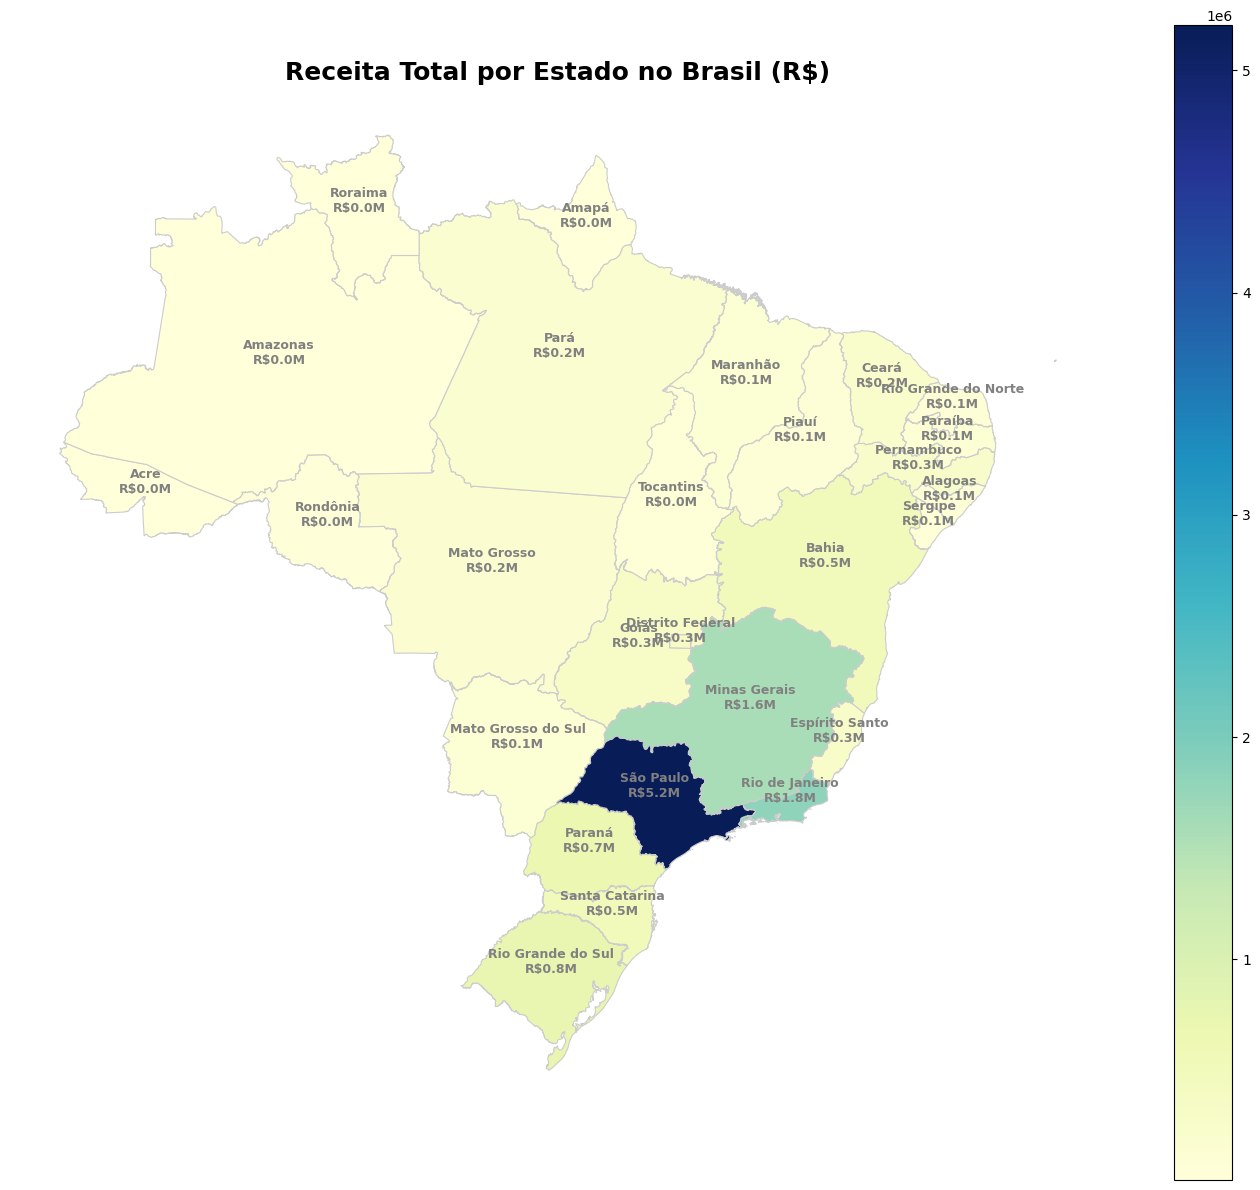

In [39]:
geo_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
br_map = gpd.read_file(geo_url)

# 1. Reprojetar para um sistema de coordenadas métrico (evita erro no cálculo do centróide)
br_map_proj = br_map.to_crs(epsg=5880)

# 2. Mesclar com os dados de receita por estado
dados_mapa = br_map_proj.merge(state_sales, left_on='name', right_on='state_name')

# 3. Calcular coordenadas dos centróides (para posicionar os rótulos corretamente)
dados_mapa['coordenadas'] = dados_mapa['geometry'].centroid

# 4. Criar o gráfico
fig, ax = plt.subplots(figsize=(14, 12))
dados_mapa.plot(
    column='order_amount',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True
)

# 5. Título e estilo
ax.set_title('Receita Total por Estado no Brasil (R$)', fontsize=18, fontweight='bold')
ax.axis('off')

# 6. Adicionar anotações com nome do estado e valor da receita
for idx, row in dados_mapa.iterrows():
    plt.annotate(
        text=f"{row['state_name']}\nR${row['order_amount'] / 1e6:.1f}M",
        xy=(row['coordenadas'].x, row['coordenadas'].y),
        ha='center',
        fontsize=9,
        color='grey',
        weight='bold'
    )

plt.tight_layout()
plt.show()




customer_state
SP    5202820.08
RJ    1824092.67
MG    1585308.03
RS     750304.02
PR     683112.34
SC     520553.34
BA     511349.99
DF     302603.94
GO     294591.95
ES     275037.31
Name: order_amount, dtype: float64


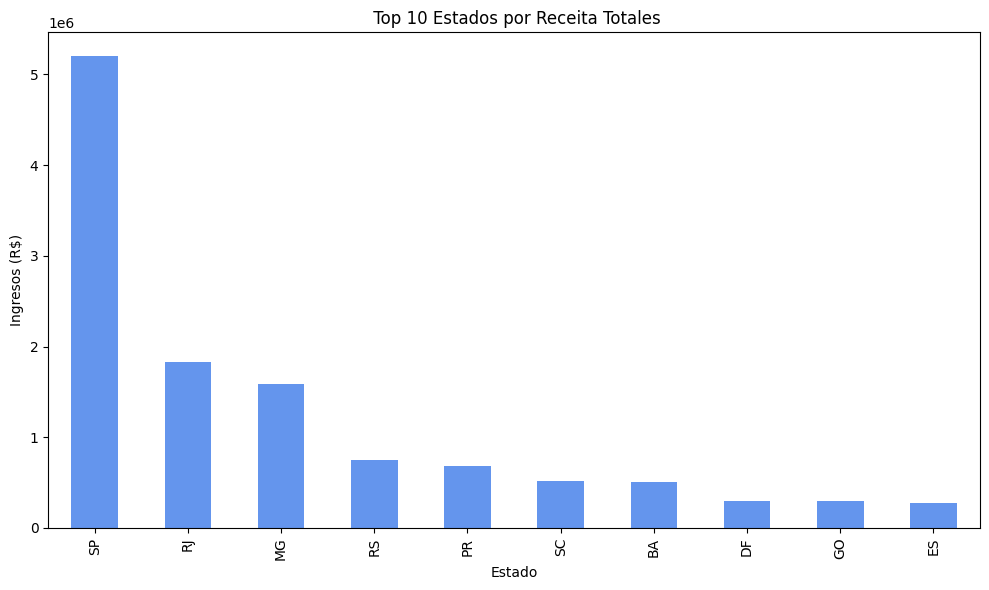

In [40]:
# === Principais estados por volume de vendas===
# Merge com dim_customer
sales_customer = fct_sales.merge(dim_customer, on='customer_id', how='left')

top_states = sales_customer.groupby('customer_state')['order_amount'].sum().sort_values(ascending=False).head(10)
print(top_states)
top_states.plot(kind='bar', figsize=(10, 6), color='cornflowerblue')
plt.title(" Top 10 Estados por Receita Totales")
plt.ylabel("Ingresos (R$)")
plt.xlabel("Estado")
plt.tight_layout()
plt.show()

- **Domínio do Sudeste:** São Paulo lidera de longe com 5,2 milhões em receitas, seguido pelo Rio de Janeiro ( 1,8 milhão) e Minas Gerais (1,6 milhão). Essa região representa o coração econômico do país e concentra o maior poder de compra.

- **Bom desempenho no Sul:** Rio Grande do Sul, Paraná e Santa Catarina adicionam entre  0,5 milhão e  0,8 milhão cada. Eles refletem mercados consolidados e infraestrutura logística favorável.

- **Oportunidades no Nordeste:** Estados como Bahia ( 0,5 milhão) e Pernambuco ( 0,3 milhão) apresentam um desempenho médio. Há potencial de crescimento com estratégias localizadas.

- **Norte e Centro-Oeste atrasados:** vários estados, como Acre, Roraima, Tocantins ou Amapá, têm receitas muito baixas ou inexistentes. Isso pode ser devido a restrições logísticas, baixa penetração digital ou menor densidade populacional.

###### Analisis da Categorias Rentaveis

In [41]:
# === Evolução temporal das ventas
monthly_summary = fct_sales.merge(dim_date, on='date_id')
monthly_summary_grouped = monthly_summary.groupby(['year', 'month']).agg({
    'order_id': 'nunique',
    'order_amount': 'sum',
    'payment_value': 'sum'
}).reset_index()

print(monthly_summary_grouped.head())


   year  month  order_id  order_amount  payment_value
0  2016      9         2        132.39         347.52
1  2016     10       308    2357424.55     3477653.43
2  2016     12         1         10.90          19.62
3  2017      1       789    7947710.44    12799271.66
4  2017      2      1733   29214058.51    40901715.47


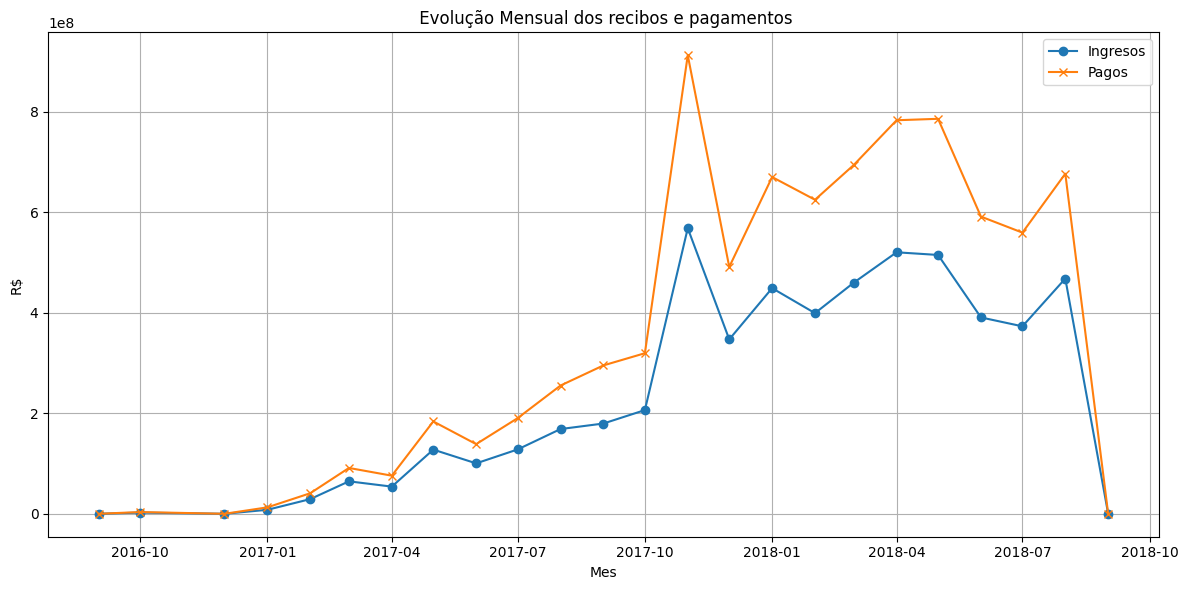

In [42]:
#  Evolução temporal das vendas Plot
monthly_summary_grouped['period'] = pd.to_datetime(monthly_summary_grouped[['year', 'month']].assign(day=1))

plt.figure(figsize=(12, 6))
plt.plot(monthly_summary_grouped['period'], monthly_summary_grouped['order_amount'], marker='o', label="Ingresos")
plt.plot(monthly_summary_grouped['period'], monthly_summary_grouped['payment_value'], marker='x', label="Pagos")
plt.title(" Evolução Mensual dos recibos e pagamentos")
plt.xlabel("Mes")
plt.ylabel("R$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- Ambos cresceram fortemente desde o início de 2017.
- Pico nos pagamentos: novembro de 2017, possivelmente devido à Natal.
- Desde 2018, os pagamentos se estabilizaram em alta; as receitas caíram ligeiramente.
- Queda acentuada em ambos em setembro de 2018 (dados incompletos ou fechamento do período).


In [43]:
# === As 10 categorias com os maiores ganhos === #
# Join com dim_product
sales_product = fct_sales.merge(dim_product, on='product_id', how='left')

top_categories = sales_product.groupby('product_category_name')['order_amount'].sum().sort_values(ascending=False).head(10)
print(top_categories)


product_category_name
health_beauty            1258574.95
watches_gifts            1205005.68
bed_bath_table           1036988.68
sports_leisure            988048.97
computers_accessories     911954.32
furniture_decor           729762.49
cool_stuff                635290.85
housewares                632248.66
auto                      592720.11
garden_tools              485256.46
Name: order_amount, dtype: float64


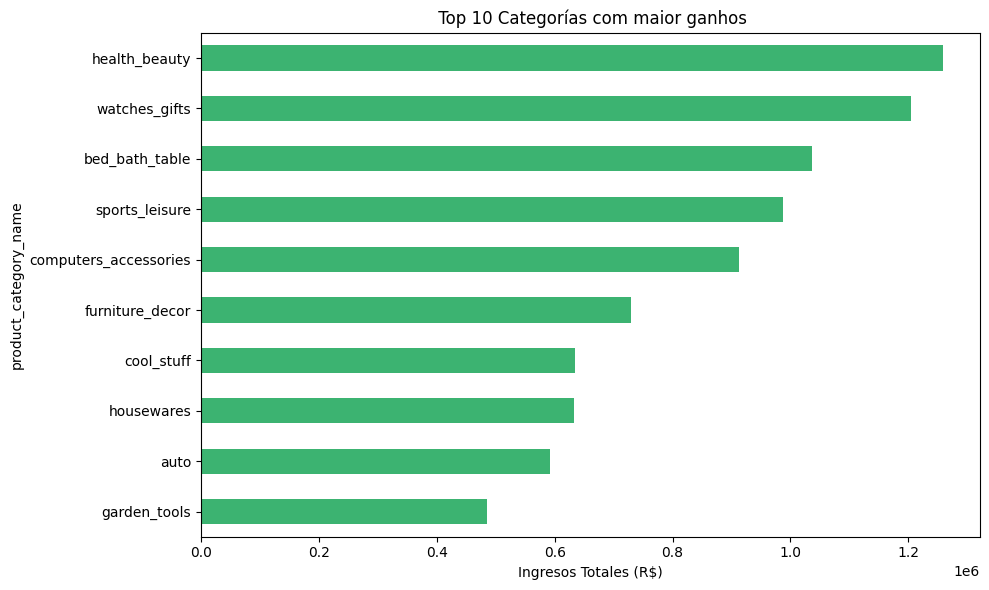

In [44]:
top_categories.plot(kind='barh', figsize=(10, 6), color='mediumseagreen')
plt.title(" Top 10 Categorías com maior ganhos")
plt.xlabel("Ingresos Totales (R$)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


- `Health_beauty` e ``watches_gifts`` lideram em receita.
- ``Cama_banho_mesa`` e ``móveis_decoração`` se destacam em casa e decoração.
- ``Computers_accessories`` e ``sports_leisure`` também são fortes em tecnologia e esportes.
- Diversos segmentos indicam uma diversificação no consumo.

In [45]:
# === Top 10 categorías com menor ganho === #
min_categories = sales_product.groupby('product_category_name')['order_amount'].sum().sort_values(ascending=True).head(10)
print(min_categories)

product_category_name
security_and_services         283.29
fashion_childrens_clothes     569.85
cds_dvds_musicals             730.00
home_comfort_2                760.27
flowers                      1110.04
diapers_and_hygiene          1567.59
arts_and_craftmanship        1814.01
la_cuisine                   2054.99
fashion_sport                2119.51
fashio_female_clothing       2803.64
Name: order_amount, dtype: float64


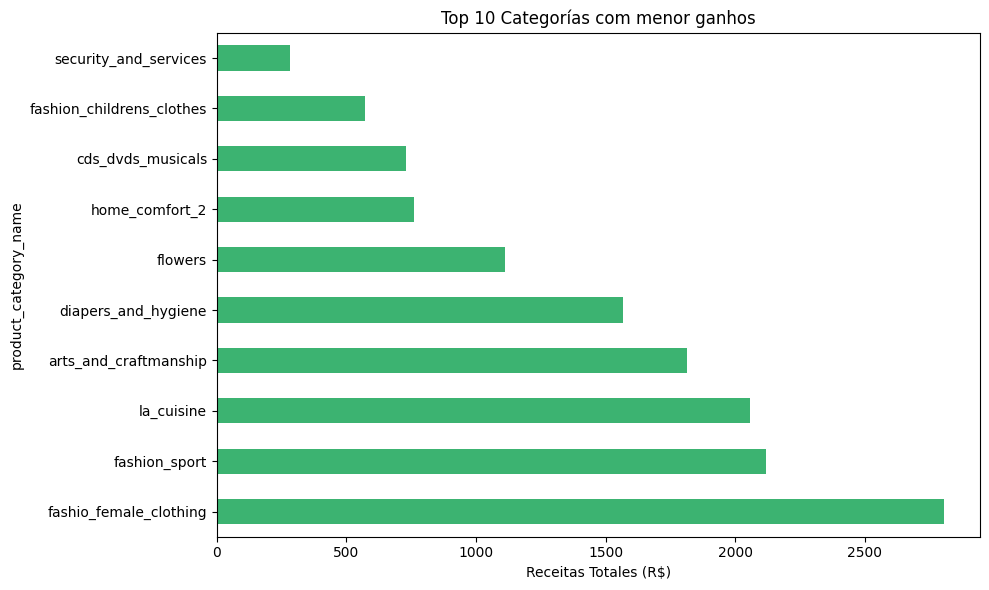

In [46]:
min_categories.plot(kind='barh', figsize=(10, 6), color='mediumseagreen')
plt.title("Top 10 Categorías com menor ganhos")
plt.xlabel("Receitas Totales (R$)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

- ``fashio_female_clothing`` lidera nas categorias de baixa renda, embora ainda seja baixa em comparação.
- ``La_cuisine`` e ``fraldas_e_higiene`` mostram potencial como nichos.
- ``Arts_and_craftmanship`` e flores refletem uma renda possivelmente sazonal ou específica de um nicho.
- ``Security_and_services`` apresenta receitas mínimas, o que sugere baixa demanda ou tíquete médio baixo.

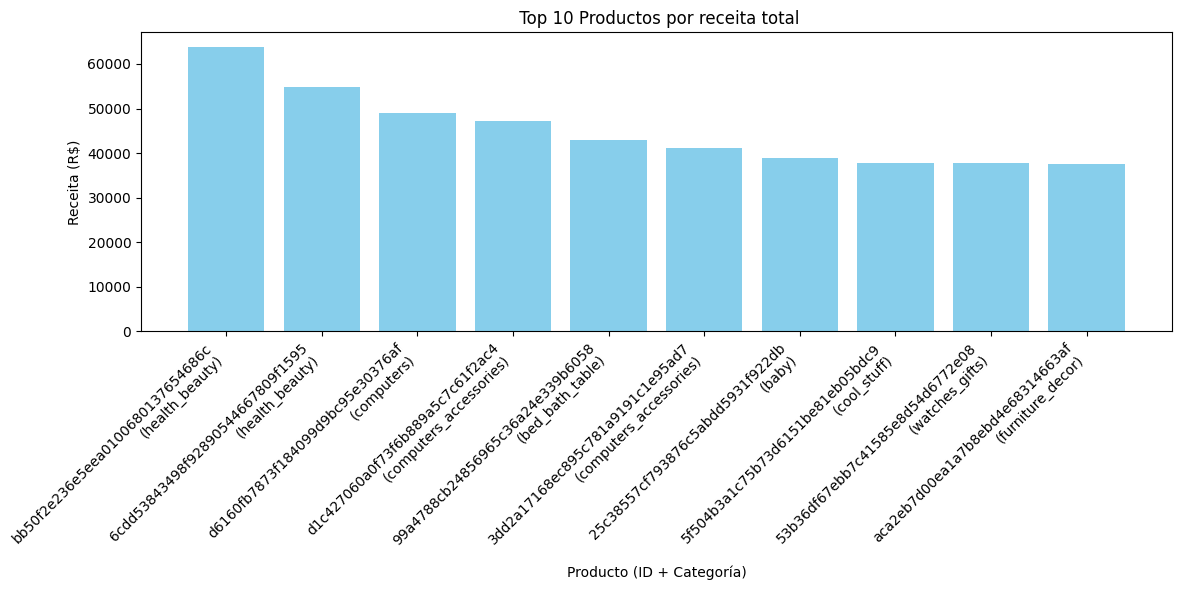

In [47]:
# Agregar la categoría a fct_sales
fct_sales_with_category = fct_sales.merge(dim_product, on='product_id', how='left')

# Agrupar por producto individual
top_products = fct_sales_with_category.groupby(['product_id', 'product_category_name'])['order_amount'] \
                                      .sum().sort_values(ascending=False).head(10).reset_index()

# Crear etiquetas con nombre de categoría
top_products['label'] = top_products['product_id'].astype(str) + '\n(' + top_products['product_category_name'] + ')'

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(top_products['label'], top_products['order_amount'], color='skyblue')
plt.title(" Top 10 Productos por receita total")
plt.ylabel("Receita (R$)")
plt.xlabel("Producto (ID + Categoría)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


- **Liderança em saúde e beleza:** essa categoria não apenas está no topo da classificação geral de receita, mas também contribui com os dois produtos mais lucrativos, consolidando sua posição como um segmento importante.

- **Computadores como um nicho forte:** “Computadores” e “computadores_acessórios” têm uma forte presença, indicando que, embora não sejam as maiores categorias em volume, seus produtos individuais podem gerar receitas significativas.

- **Representação alinhada com as principais categorias:** A maioria desses produtos vem de categorias proeminentes, como “bed_bath_table”, “cool_stuff” e “watches_gifts”, reforçando a consistência entre a análise por produto e por categoria.

- **Ausência de categorias fracas:** Nenhum dos produtos vem de segmentos de baixo desempenho, como “flowers”, “cds_dvds_musicals” ou “security_and_services”, confirmando sua capacidade limitada de geração de receita.

##### Top Sellers

- Este script para fazer um plot tem como objetivo identificar vendedores especializados, ou seja, aqueles cujas vendas são altamente concentradas em uma única categoria de produto (mais de 80% das vendas totais). O gráfico final mostra as 10 categorias mais comuns entre esses vendedores especializados.



In [48]:
# Juntar as tabelas de vendas com produtos e vendedores
sales_full = fct_sales.merge(dim_product, on='product_id', how='left') \
                      .merge(dim_seller, on='seller_id', how='left')


In [49]:
# Crear um dataframe com receita total por vendedor e categoria
seller_product_mix = sales_full.groupby(['seller_id', 'product_category_name'])['order_amount'].sum().reset_index()
seller_product_mix.rename(columns={'order_amount': 'total_sales'}, inplace=True)


In [50]:
# Calcular o total de vendas por vendedor
seller_totals = seller_product_mix.groupby('seller_id')['total_sales'].sum().reset_index()

# Juntar com os totais para calcular a proporção por categoria
seller_product_mix = seller_product_mix.merge(seller_totals, on='seller_id', suffixes=('', '_seller_total'))
seller_product_mix['category_share'] = seller_product_mix['total_sales'] / seller_product_mix['total_sales_seller_total']

# Filtrar os vendedores especializados (>80% em uma única categoria)
specialized_sellers = seller_product_mix[seller_product_mix['category_share'] > 0.8]


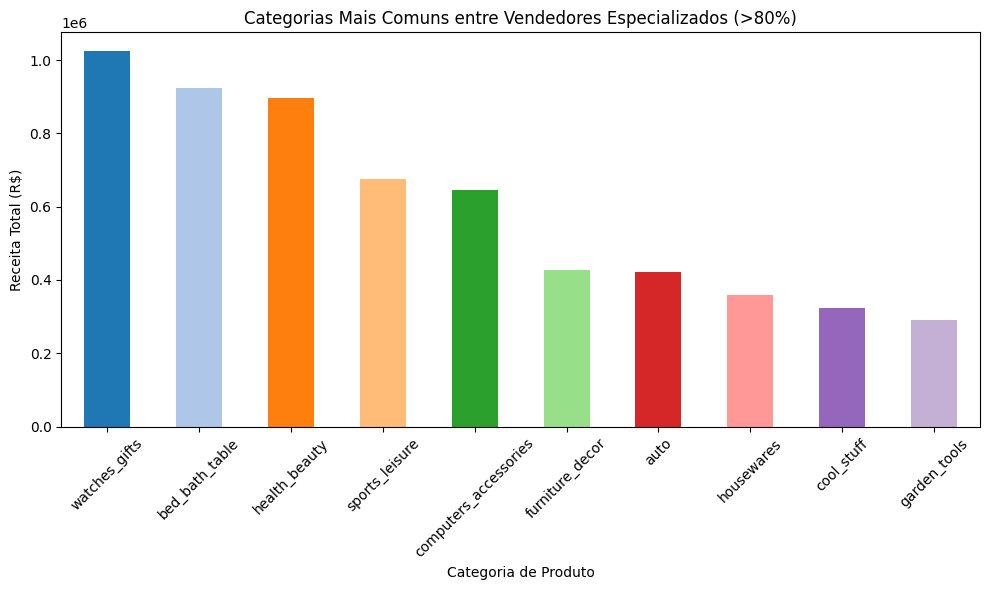

In [51]:
# Obter as 10 categorias mais comuns entre vendedores especializados
top_specialized_categories = specialized_sellers.groupby('product_category_name')['total_sales'].sum() \
                                                .sort_values(ascending=False).head(10)

# Cores personalizadas para as barras
cores = sns.color_palette("tab20", len(top_specialized_categories))

# Plotar o gráfico de barras
top_specialized_categories.plot(kind='bar', figsize=(10, 6), color=cores)
plt.title("Categorias Mais Comuns entre Vendedores Especializados (>80%)")
plt.ylabel("Receita Total (R$)")
plt.xlabel("Categoria de Produto")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- As categorias watches_gifts, bed_bath_table e health_beauty são as mais comuns entre os vendedores especializados.
- Há uma forte presença de categorias relacionadas a casa e cuidados pessoais.
- Essa abordagem pode indicar alta concorrência entre os vendedores de nicho nessas categorias, mas também maior especialização, o que poderia se traduzir em melhores margens ou fidelidade do cliente.

- Este código identifica o melhor vendedor em termos de receita dentro de cada categoria de produto e exibe os 10 principais casos com maiores valores de venda. O gráfico mostra a categoria e o vendedor líder, facilitando a identificação de vendedores dominantes por nicho.

In [52]:
# Unir dados de vendas com produto e vendedor
sales_enriched = fct_sales.merge(dim_product, on='product_id', how='left') \
                          .merge(dim_seller, on='seller_id', how='left')

# Agrupar por vendedor e categoria de produto
seller_category_sales = sales_enriched.groupby(['product_category_name', 'seller_id'])['order_amount'] \
                                      .sum().reset_index()

# Selecionar o top 1 vendedor por categoria (com maior receita)
top_sellers_by_category = seller_category_sales.sort_values(['product_category_name', 'order_amount'], ascending=[True, False]) \
                                               .drop_duplicates(subset='product_category_name')

# Ordenar pelas categorias com maior receita total
top_sellers_by_category = top_sellers_by_category.sort_values(by='order_amount', ascending=False).head(10)


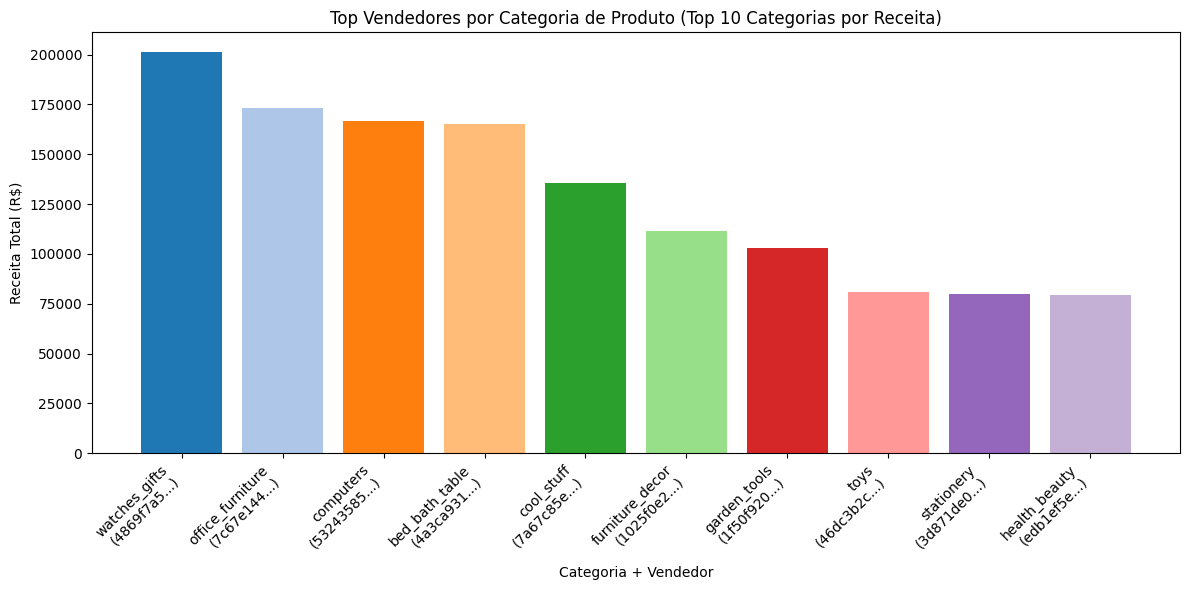

In [53]:
# Top sellers
top_sellers_by_category['label'] = top_sellers_by_category['product_category_name'] + "\n(" + top_sellers_by_category['seller_id'].str[:8] + "...)"

# Style
cores = sns.color_palette("tab20", len(top_sellers_by_category))

# Barplot
plt.figure(figsize=(12, 6))
plt.bar(top_sellers_by_category['label'], top_sellers_by_category['order_amount'], color=cores)
plt.title("Top Vendedores por Categoria de Produto (Top 10 Categorias por Receita)")
plt.ylabel("Receita Total (R$)")
plt.xlabel("Categoria + Vendedor")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


- As mesmas categorias de alto foco (watches_gifts, bed_bath_table, furniture_decor, garden_tools, etc.) também aparecem entre as mais lucrativas.
- Isso sugere que a especialização está correlacionada com o sucesso comercial em determinadas categorias.
- Algumas categorias, como brinquedos ou artigos de papelaria, aparecem aqui, mas não no gráfico acima, indicando que, nesses casos, os mais vendidos não são necessariamente especializados, mas possivelmente diversificados.

**Cruzamento com análises anteriores**

- watches_gifts aparece consistentemente em todas as métricas: é uma categoria com muitos produtos vendidos, boa rotatividade e alta especialização.
- health_beauty e bed_bath_table também apresentam alto volume e especialização, o que as torna nichos potencialmente muito lucrativos.
- Categorias como brinquedos ou artigos de papelaria, embora tenham um bom volume de negócios, não se destacam em especialização, o que poderia implicar em mercados maiores, mas menos concentrados.

### Fact_Funnel


In [54]:
fct_funnel.head()

,lead_id,event_date_id,campaign_id,lead_flag,qualified_flag,deal_closed_flag,time_to_close,business_segment
0,dac32acd4db4c29c230538b72f8dd87d,20180201,88740e65d5d6b056e0cda098e1ea6313,1,1,0,NaN,NaN
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,20171020,007f9098284a86ee80ddeb25d53e0af8,1,1,0,NaN,NaN
2,b4bc852d233dfefc5131f593b538befa,20180322,a7982125ff7aa3b2054c6e44f9d28522,1,1,0,NaN,NaN
3,6be030b81c75970747525b843c1ef4f8,20180122,d45d558f0daeecf3cccdffe3c59684aa,1,1,0,NaN,NaN
4,5420aad7fec3549a85876ba1c529bd84,20180221,b48ec5f3b04e9068441002a19df93c6c,1,1,1,5.0,pet


In [55]:
fct_funnel.describe()

,event_date_id,lead_flag,qualified_flag,deal_closed_flag,time_to_close
count,7.999000e+03,7999.0,7999.0,7999.000000,841.000000
mean,2.017798e+07,1.0,1.0,0.105138,48.500595
std,4.056615e+03,0.0,0.0,0.306751,75.352823
min,2.017061e+07,1.0,1.0,0.000000,0.000000
25%,2.017123e+07,1.0,1.0,0.000000,5.000000
50%,2.018022e+07,1.0,1.0,0.000000,14.000000
75%,2.018042e+07,1.0,1.0,0.000000,55.000000
max,2.018053e+07,1.0,1.0,1.000000,427.000000


In [56]:
conversion_rate = fct_funnel['deal_closed_flag'].mean()
print(f"Tasa de conversión global: {conversion_rate:.2%}")



Tasa de conversión global: 10.51%


**Leads e qualificação:**
- Todos os registros são leads qualificados (lead_flag = qualified_flag = 1), indicando que o funil já começa com leads com potencial.
- Conversão em venda: apenas 10,5% (média deal_closed_flag = 0,105) dos leads qualificados fecham uma venda, refletindo uma baixa taxa de conversão.

**Tempo para fechar (negócios fechados):**
- Média: ~48,5 dias.
- Mediana: 14 dias → Há casos rápidos, mas também fechamentos longos (até 427 dias), com uma alta dispersão (std = 75 dias).

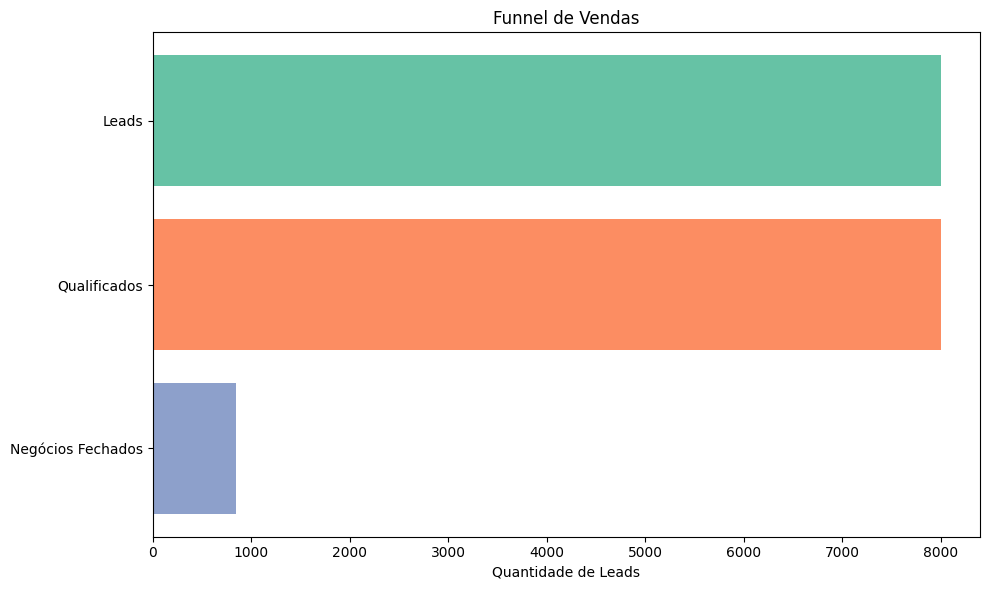

In [57]:
# Conteo das etapas do embudo
lead_count = fct_funnel['lead_flag'].sum()
qualified_count = fct_funnel['qualified_flag'].sum()
closed_count = fct_funnel['deal_closed_flag'].sum()

# Dados do funil
funnel_data = [lead_count, qualified_count, closed_count]
stages = ['Leads', 'Qualificados', 'Negócios Fechados']

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(stages, funnel_data, color=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Funnel de Vendas')
plt.xlabel('Quantidade de Leads')
plt.gca().invert_yaxis()  # Coloca o topo do funil em cima
plt.tight_layout()
plt.show()


**Funil de vendas**
- Todos os leads são qualificados, mas apenas 10,5% são convertidos em vendas.
- Grande perda entre “qualificado” e “fechado”, indicando um problema na fase de fechamento, não na aquisição ou qualificação.


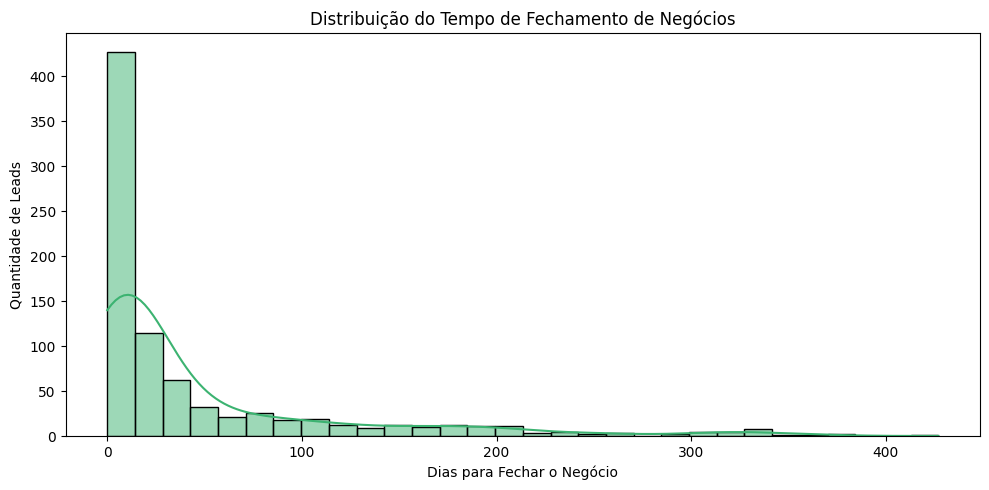

In [58]:
# So Lead fechados (deal_closed_flag == 1)
closed_deals = fct_funnel[fct_funnel['deal_closed_flag'] == 1]

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(closed_deals['time_to_close'], bins=30, kde=True, color='mediumseagreen')
plt.title('Distribuição do Tempo de Fechamento de Negócios')
plt.xlabel('Dias para Fechar o Negócio')
plt.ylabel('Quantidade de Leads')
plt.tight_layout()
plt.show()


**Tempo até o fechamento**
- A maioria dos negócios fechados ocorre nos primeiros 15 dias, mas há uma longa cauda de fechamentos tardios (outliers).
- Isso sugere que o acompanhamento rápido é fundamental para aumentar as conversões.

In [59]:
# Verificar quantos segmentos cada campanha tem com leads fechados
segmentos_por_campaña = fct_funnel[fct_funnel['deal_closed_flag'] == 1].groupby('campaign_id')['business_segment'].nunique()
print(segmentos_por_campaña[segmentos_por_campaña > 1])


campaign_id
007f9098284a86ee80ddeb25d53e0af8     3
0218f6be0b76aca72ab4d00ee9e8cf10     6
0b9430edcbf2d9a95148c806af2b6699     2
1722481ac9e5371e5099dea226b5421d     2
1baca9df5850e5ba75545d8b2eb8d966     2
1ceb590cd1e00c7ee95220971f82693d     6
21a104c3279681d9856b8a48723c4fee     3
2228a43ac0bc372e25f9569e69fc9015     2
22c29808c4f815213303f8933030604c    28
241f79c7a8fe0270f4fb79fcbbcd17ad     9
27cd3540bace1f4a4b2bc6d319b0553c     2
2f08471dfb83baef522f952438a36f6e     3
30077c17f2ec5010a82e37ad8925b95f     8
330b9d44078a1ae5a221d655dcb77afa     4
358adb2fee9a122549618e46925a00a5     2
35c9b150ab36fe584c1f24fd458c453a     8
36120633c8737035fbabf079082f4ec1     2
37cf94070e940a694969304de58debe1     2
40dec9f3d5259a3d2dbcdab2114fae47    23
4aab772aeb9833c170d8ea5413e02eac     3
58326e62183c14b0c03085c33b9fdc44    13
5dc848e7dd9418dffe183215b8ff0bc1     3
649b7b8b46b254497e92038d88f6ced8     4
65d9f9d71e562365e8b44037c2888d98     5
68f817c510c978e3a3a7474ad2aeb75c     2
6b6c0934205e8

<ipython-input-60-98b81c815264>:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


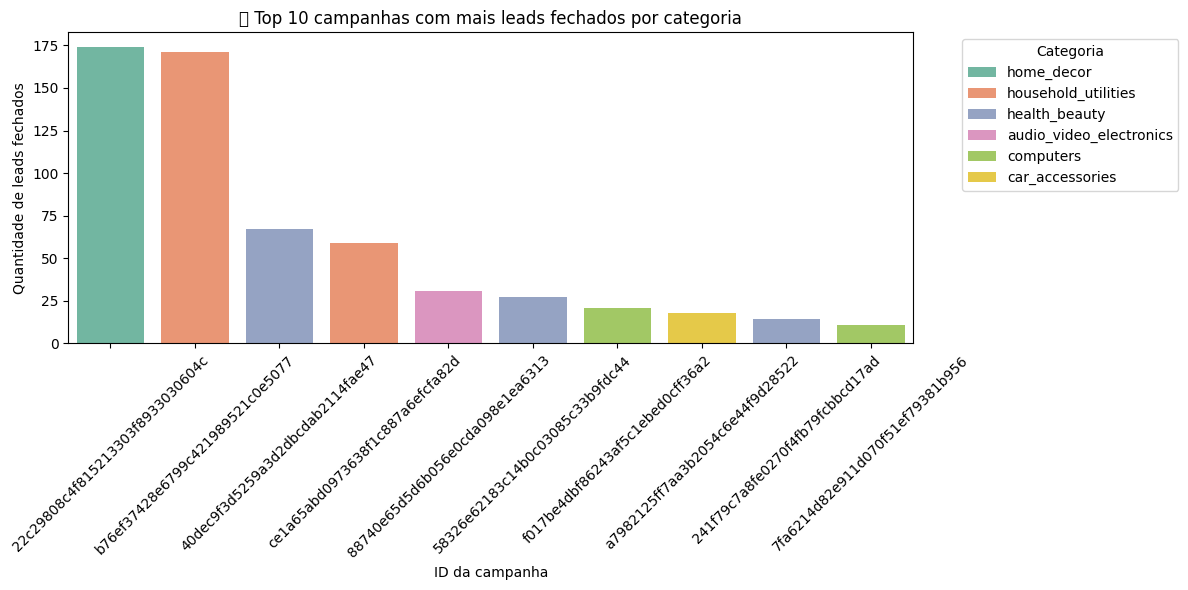

In [60]:
# 1. Filtrar apenas campanhas com leads fechados
cerrados = fct_funnel[fct_funnel['deal_closed_flag'] == 1]

# 2. Obter a categoria dominante por campanha
categoria_dominante = (
    cerrados.groupby(['campaign_id', 'business_segment'])['lead_id']
    .count()
    .reset_index()
    .sort_values(['campaign_id', 'lead_id'], ascending=[True, False])
    .drop_duplicates('campaign_id')
)

# 3. Contar os leads fechados por campanha
resumen_campanas = (
    cerrados.groupby('campaign_id')
    .agg(leads_cerrados=('lead_id', 'count'))
    .reset_index()
)

# 4. Juntar as informações de categoria dominante
resumen_campanas = resumen_campanas.merge(categoria_dominante, on='campaign_id')

# 5. Selecionar o top 10
top_10 = resumen_campanas.sort_values(by='leads_cerrados', ascending=False).head(10)

# 6. Visualizar com seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10, x='campaign_id', y='leads_cerrados', hue='business_segment', dodge=False, palette='Set2')
plt.title("📊 Top 10 campanhas com mais leads fechados por categoria")
plt.ylabel("Quantidade de leads fechados")
plt.xlabel("ID da campanha")
plt.xticks(rotation=45)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




**Campanhas mais bem-sucedidas:**
- As campanhas categoria home_decor  e categoria household_utilities lideram de longe em número de leads fechados.
- Ambos ultrapassam 170 leads fechados, indicando um desempenho de conversão muito mais alto em comparação com os demais.

**Distribuição por categoria:**
- As campanhas mais eficazes estão concentradas em três    categorias principais: ``decoração_doméstica``, ``utilidades_domésticas`` e ``saúde_beleza.``
- Isso sugere que esses segmentos de negócios podem ter maior demanda ou melhor execução de campanha.

**Oportunidades por categoria:**
- Campanhas de ``áudio_vídeo_eletrônicos``, ``computadores e acessórios`` para carros também aparecem, embora com menor volume.
- Elas podem representar nichos com potencial se a estratégia for otimizada ou se os recursos investidos forem aumentados.

**Relação entre campanhas bem-sucedidas e categorias lucrativas previamente identificadas:**

- As categorias que predominam nos leads fechados (``home_decor, household_utilities, health_beauty``) já haviam sido destacadas como lucrativas ou de alto potencial.

- **Validação por volume + eficácia:**
  - Eles não apenas são populares (como a análise anterior poderia ter indicado), mas também fecham muitos leads, o que sugere que têm demanda e capacidade de conversão efetiva.
  - ``health_beauty``, que também apareceu em segmentos de interesse, confirma sua relevância.

### Fact_Reviews

In [61]:
fct_reviews.head()

,review_id,review_date_id,customer_id,customer_city,customer_state,product_id,price_range_id,review_score,review_count,review_response_time
0,7bc2406110b926393aa56f80a40eba40,20180118,41dcb106f807e993532d446263290104,osasco,SP,fd25ab760bfbba13c198fa3b4f1a0cd3,high,4,1,0.0
4,80e641a11e56f04c1ad469d5645fdfde,20180310,8a2e7ef9053dea531e4dc76bd6d853e6,nova odessa,SP,be0dbdc3d67d55727a65d4cd696ca73c,medium,5,1,0.0
6,228ce5500dc1d8e020d8d1322874b6f0,20180217,e226dfed6544df5b7b87a48208690feb,santo antonio de jesus,BA,d1c427060a0f73f6b889a5c7c61f2ac4,medium,5,1,0.0
8,e64fb393e7b32834bb789ff8bb30750e,20170421,de6dff97e5f1ba84a3cd9a3bc97df5f6,gravatal,SC,52c80cedd4e90108bf4fa6a206ef6b03,high,5,1,0.0
9,f7c4243c7fe1938f181bec41a392bdeb,20180301,5986b333ca0d44534a156a52a8e33a83,curitibanos,SC,3880d25d502b15b1de6fddc42ad1d67a,high,5,1,0.0


In [62]:
fct_reviews.describe()

,review_date_id,review_score,review_count,review_response_time
count,8.764100e+04,87641.000000,87641.0,87641.000000
mean,2.017616e+07,4.284650,1.0,0.129038
std,4.865513e+03,1.152814,0.0,1.396063
min,2.016102e+07,1.000000,1.0,0.000000
25%,2.017092e+07,4.000000,1.0,0.000000
50%,2.018013e+07,5.000000,1.0,0.000000
75%,2.018052e+07,5.000000,1.0,0.000000
max,2.018083e+07,5.000000,1.0,106.000000


**Clientes satisfeitos**
- Média de avaliação: 4,19 | Mediana: 5 → maioria das avaliações são positivas.

**Respostas geralmente rápidas**
- 75% das respostas têm tempo = 0 dias (possível erro ou respostas imediatas).

**Outliers em tempo de resposta**
- Máximo: 106 dias (muito acima da média de 0,13 dias) → casos extremos.

In [63]:
# So as tuplas que tem valora em review_response_time
fact_reviews = fct_reviews[fct_reviews["review_response_time"] != 0]

<ipython-input-64-653cab85102e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='review_score', data=fact_reviews, palette='viridis')


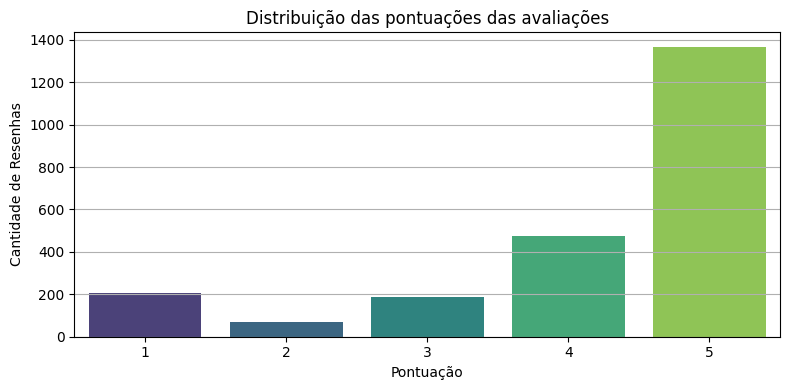

In [64]:
# === 1. Distribuição das pontuações de avaliação ===
plt.figure(figsize=(8, 4))
sns.countplot(x='review_score', data=fact_reviews, palette='viridis')
plt.title("Distribuição das pontuações das avaliações")
plt.xlabel("Pontuação")
plt.ylabel("Cantidade de Resenhas")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

- A grande maioria das avaliações é de 5 estrelas, indicando alta satisfação geral.
- As avaliações negativas (1 e 2) são relativamente poucas, mas não desprezíveis.

<ipython-input-65-6678daf3c8a7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


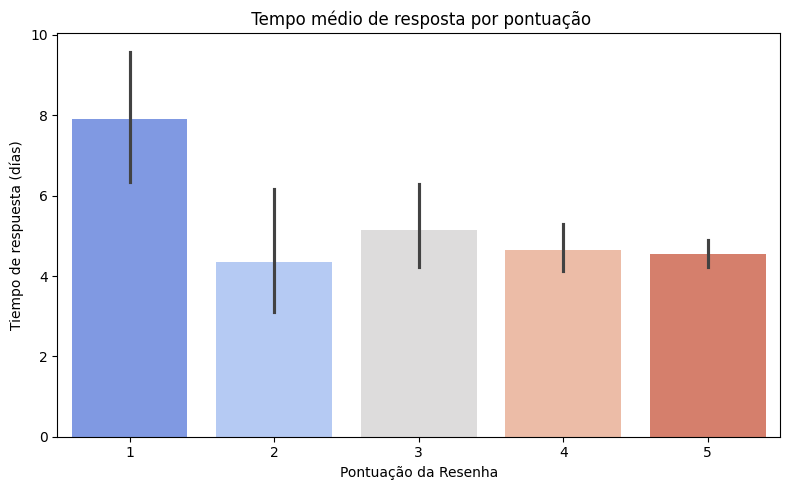

In [65]:
# == Tempo médio de resposta por pontuação ===
plt.figure(figsize=(8, 5))
sns.barplot(
    x='review_score',
    y='review_response_time',
    data=fact_reviews,
    palette='coolwarm'
)
plt.title(' Tempo médio de resposta por pontuação')
plt.xlabel('Pontuação da Resenha')
plt.ylabel('Tiempo de respuesta (días)')
plt.tight_layout()
plt.show()


- Há uma relação inversa entre a pontuação da avaliação e o tempo de resposta: pontuações mais baixas estão associadas a atrasos maiores na resposta.
- Isso sugere que uma resposta rápida pode estar relacionada a uma maior satisfação do cliente.

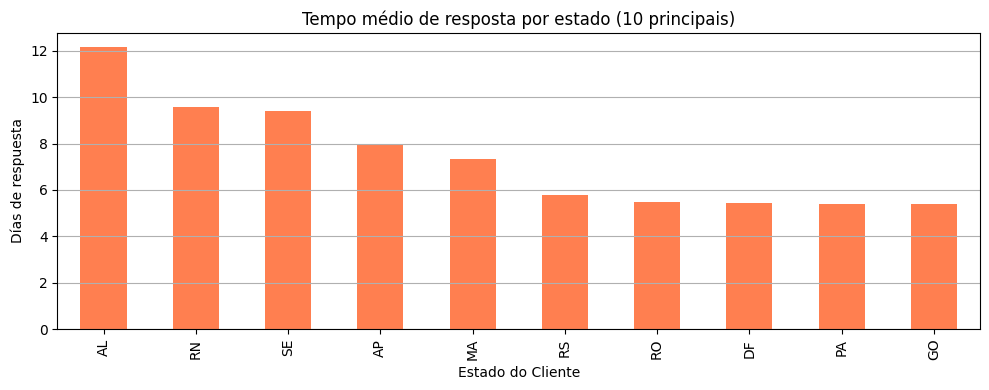

In [66]:
# === Tempo médio de resposta por status do cliente ===
avg_response_by_state = fact_reviews.groupby("customer_state")["review_response_time"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 4))
avg_response_by_state.plot(kind='bar', color='coral')

plt.title("Tempo médio de resposta por estado (10 principais)")
plt.xlabel("Estado do Cliente")
plt.ylabel("Días de respuesta")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

- Estados como AL, RN e SE têm tempos de resposta notavelmente mais altos, o que pode indicar problemas logísticos ou de serviço específicos nessas regiões.
- Isso abre oportunidades para otimizar as operações localmente.

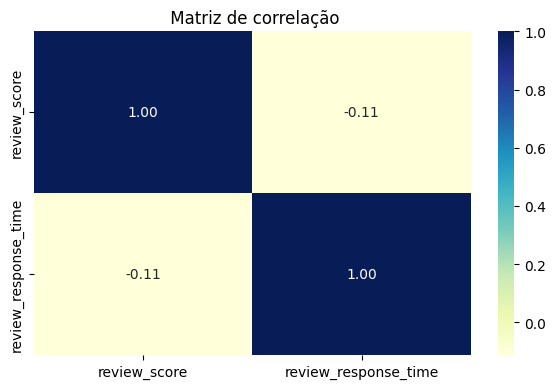

In [67]:
# === Matriz de correlação (somente review_score e review_response_time) ===
corr_data = fact_reviews[["review_score", "review_response_time"]]
plt.figure(figsize=(6, 4))
sns.heatmap(corr_data.corr(), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title(" Matriz de correlação")
plt.tight_layout()
plt.show()

- Há uma leve correlação negativa entre a pontuação da avaliação e o tempo de resposta (-0,11), o que reforça o que foi observado acima: quanto maior o atraso, menor a satisfação.

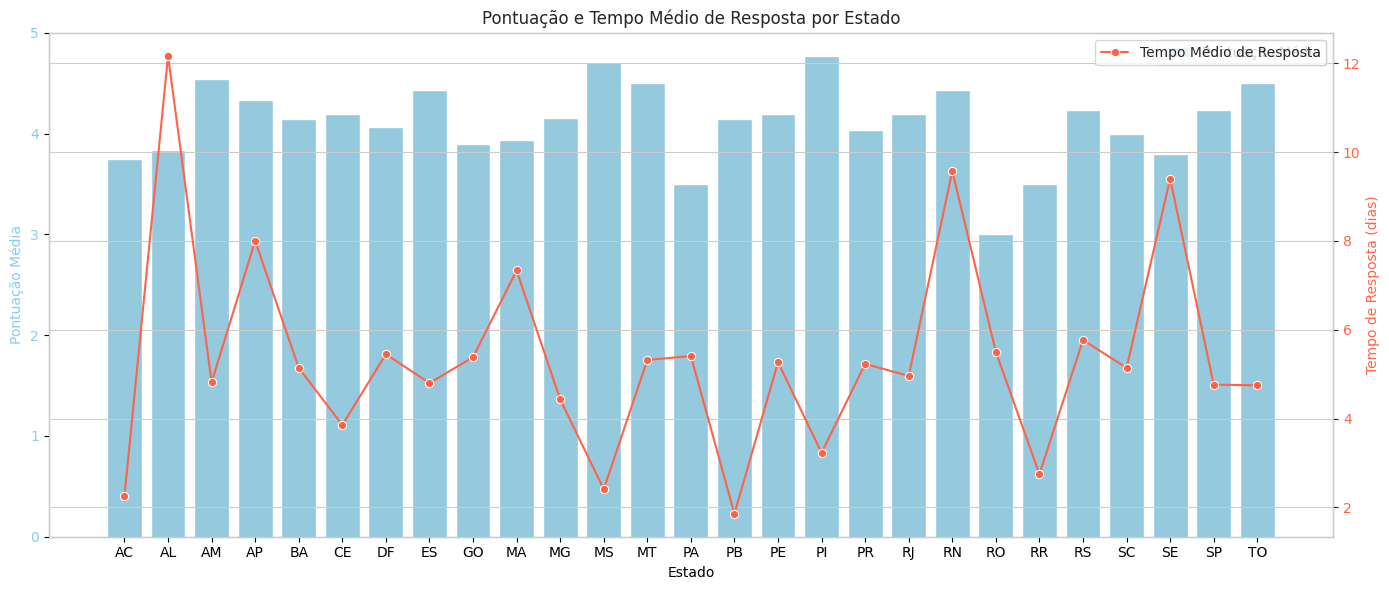

In [68]:
# Agrupamos por estado e calculamos médias
state_summary = fact_reviews.groupby('customer_state').agg({
    'review_score': 'mean',
    'review_response_time': 'mean'
}).reset_index()

# Ordenamos alfabeticamente por estado
state_summary = state_summary.sort_values(by='customer_state')

# Configuração do gráfico
fig, ax1 = plt.subplots(figsize=(14, 6))

sns.set_style("whitegrid")

# Gráfico de barras para a média de avaliações
sns.barplot(
    data=state_summary,
    x='customer_state',
    y='review_score',
    color='skyblue',
    label='Pontuação Média',
    ax=ax1
)

ax1.set_ylabel('Pontuação Média', color='skyblue')
ax1.set_xlabel('Estado')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_ylim(0, 5)

# Criamos um segundo eixo Y
ax2 = ax1.twinx()

# Gráfico de linha para o tempo médio de resposta
sns.lineplot(
    data=state_summary,
    x='customer_state',
    y='review_response_time',
    color='tomato',
    label='Tempo Médio de Resposta',
    ax=ax2,
    marker='o'
)

ax2.set_ylabel('Tempo de Resposta (dias)', color='tomato')
ax2.tick_params(axis='y', labelcolor='tomato')

# Título e layout
plt.title('Pontuação e Tempo Médio de Resposta por Estado')
fig.tight_layout()
plt.show()



| Estado | Receita Total (R$) | Satisfação Média | Tempo Médio de Resposta (dias) | Análise |
|--------|--------------------|------------------|-------------------------------|---------|
| SP     | 5,2M               | Alta (~4,5)      | Baixo (~5)                    | Excelente equilíbrio entre vendas e atendimento |
| RJ     | 1,8M               | Moderada         | Médio (~5–6)                  | Alta receita com espaço para melhorar atendimento |
| MG     | 1,6M               | Alta (>4,5)      | Baixo (~4,5)                  | Muito bom desempenho geral |
| RS     | 0,8M               | Alta             | Médio (~5,5)                  | Sólido, mas pode ganhar eficiência |
| PR     | 0,7M               | Alta             | Médio                         | Consistente, com potencial de crescimento |
| SC     | 0,5M               | Alta             | Médio                         | Estável, pode melhorar em receita |
| BA     | 0,5M               | Boa              | Médio                         | Equilibrado, porém sem destaque |
| DF     | 0,3M               | Alta             | Baixo (~5)                    | Boa operação, pode escalar vendas |
| GO     | 0,3M               | Alta             | Baixo                         | Bom serviço, receita limitada |
| ES     | 0,3M               | Alta             | Médio                         | Atendimento positivo, receita modesta |
| AL     | 0,1M               | Baixa (<4,0)     | Muito alto (~12)             | Atendimento ineficiente, baixa receita |
| RN     | 0,1M               | Baixa            | Muito alto (~9,5)            | Urgente melhorar tempo de resposta |
| SE     | 0,1M               | Moderada         | Alto (~9,5)                  | Atendimento fraco impactando desempenho |
| MS     | 0,1M               | Alta             | Baixo (~3–4)                 | Bom atendimento, precisa crescer em receita |
| PA     | 0,2M               | Baixa            | Muito baixo (~2)             | Resposta rápida, mas baixa qualidade |
| PB     | 0,1M               | Baixa            | Muito baixo (~1,8)           | Eficiência de resposta não garante satisfação |


## Consultas

### Import de SQL y creacion de Index

In [69]:
import sqlite3
import pandas as pd

# Crie as conexões com o banco de dados (o arquivo .db é criado)
conn = sqlite3.connect('ecommerce_analysis.db')
cursor = conn.cursor()

In [70]:
# Tabelas de dimenções
dim_date.to_sql('dim_date', conn, if_exists='replace', index=False)
dim_customer.to_sql('dim_customer', conn, if_exists='replace', index=False)
dim_product.to_sql('dim_product', conn, if_exists='replace', index=False)
dim_seller.to_sql('dim_seller', conn, if_exists='replace', index=False)
dim_prospect.to_sql('dim_prospect', conn, if_exists='replace', index=False)
dim_campaign.to_sql('dim_campaign', conn, if_exists='replace', index=False)
dim_price_range.to_sql('dim_price_range', conn, if_exists='replace', index=False)
dim_business_segment.to_sql('dim_business_segment', conn, if_exists='replace', index=False)

# Tabelas de factos
fct_sales.to_sql('fct_sales', conn, if_exists='replace', index=False)
fct_funnel.to_sql('fct_funnel', conn, if_exists='replace', index=False)
fct_reviews.to_sql('fct_reviews', conn, if_exists='replace', index=False)

87641

In [71]:
# Indices para melhorar a búsqueda
index_queries = [
    "CREATE INDEX idx_fct_sales_date ON fct_sales(date_id)",
    "CREATE INDEX idx_fct_sales_customer ON fct_sales(customer_id)",
    "CREATE INDEX idx_fct_sales_product ON fct_sales(product_id)",
    "CREATE INDEX idx_fct_funnel_lead ON fct_funnel(lead_id)",
    "CREATE INDEX idx_fct_reviews_date ON fct_reviews(review_date_id)"
]

for query in index_queries:
    cursor.execute(query)
conn.commit()

### QUERIES

#### 1. Análisis de Rentabilidad (Roll-up/drill-down/drill-across)

In [72]:
# Separar as consultas individuais
roll_up_query = """
SELECT
    p.product_category_name,
    SUM(s.payment_value) * 0.4 AS margen_estimado,
    COUNT(DISTINCT s.seller_id) AS num_vendedores,
    COUNT(DISTINCT s.order_id) AS num_pedidos
FROM fct_sales s
JOIN dim_product p ON s.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY margen_estimado DESC;
"""
rentabilidad_por_categoria = pd.read_sql(roll_up_query, conn)

# Mostrar os resultados
print("Rentabilidade por categoría:")
print(rentabilidad_por_categoria.head())

Rentabilidade por categoría:
   product_category_name  margen_estimado  num_vendedores  num_pedidos
0         bed_bath_table       685021.468             196         9417
1          health_beauty       662965.672             492         8835
2  computers_accessories       634132.180             287         6689
3        furniture_decor       572070.556             370         6449
4          watches_gifts       571686.672             101         5624


In [73]:
drill_down_query = """
WITH categorias_baja_competencia AS (
    SELECT
        p.product_category_name,
        COUNT(DISTINCT s.seller_id) AS num_vendedores
    FROM fct_sales s
    JOIN dim_product p ON s.product_id = p.product_id
    GROUP BY p.product_category_name
    HAVING COUNT(DISTINCT s.seller_id) <= 5
    ORDER BY num_vendedores ASC
    LIMIT 10
)
SELECT
    p.product_id,
    p.product_category_name,
    SUM(s.payment_value) * 0.4 AS margen_estimado,
    COUNT(DISTINCT s.order_id) AS num_pedidos
FROM fct_sales s
JOIN dim_product p ON s.product_id = p.product_id
WHERE p.product_category_name IN (
    SELECT product_category_name FROM categorias_baja_competencia
)
GROUP BY p.product_id, p.product_category_name
ORDER BY margen_estimado DESC;
"""

# Executar as consultas separadamente
productos_baja_competencia = pd.read_sql(drill_down_query, conn)

# Mostrar os resultados
print("\nProdutos em categorías com baixa competencia:")
print(productos_baja_competencia.head())


Produtos em categorías com baixa competencia:
                         product_id              product_category_name  \
0  726b4e18f00255e2e63491bcba3f60b8  furniture_mattress_and_upholstery   
1  ec5b3c8bb77ad22278f6e9d719a83de3                     home_comfort_2   
2  1dceebcc5f23c02ea23e16d5bedca000                  cds_dvds_musicals   
3  33900d427fa4bd3f509cdacda72e84a3                         la_cuisine   
4  f4b3b257580c1430e51d71dd731273c2  furniture_mattress_and_upholstery   

   margen_estimado  num_pedidos  
0         1115.496           22  
1          490.988           20  
2          479.772           12  
3          322.216            2  
4          242.452            4  


**Rentabilidade por categoria**
- ``cama_banho_mesa, saúde_beleza e computadores_acessórios`` lideram em margem estimada (> R$ 600 mil).
- ``watches_gifts`` combina boa lucratividade com baixa concorrência (apenas 101 vendedores).

**Produtos com Baixa Concorrência**
- Nichos como ``furniture_mattress_and_upholstery, home_comfort_2 e cds_dvds_musicals`` têm poucos vendedores e margens atraentes.
- Ideal para estratégias de nicho devido à baixa saturação.


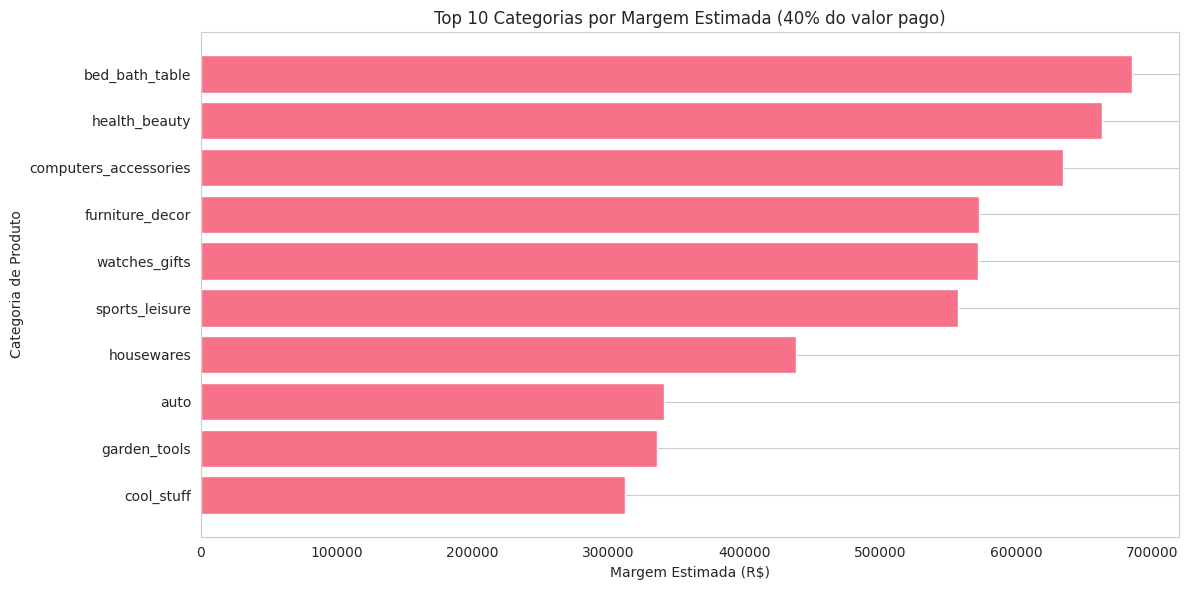

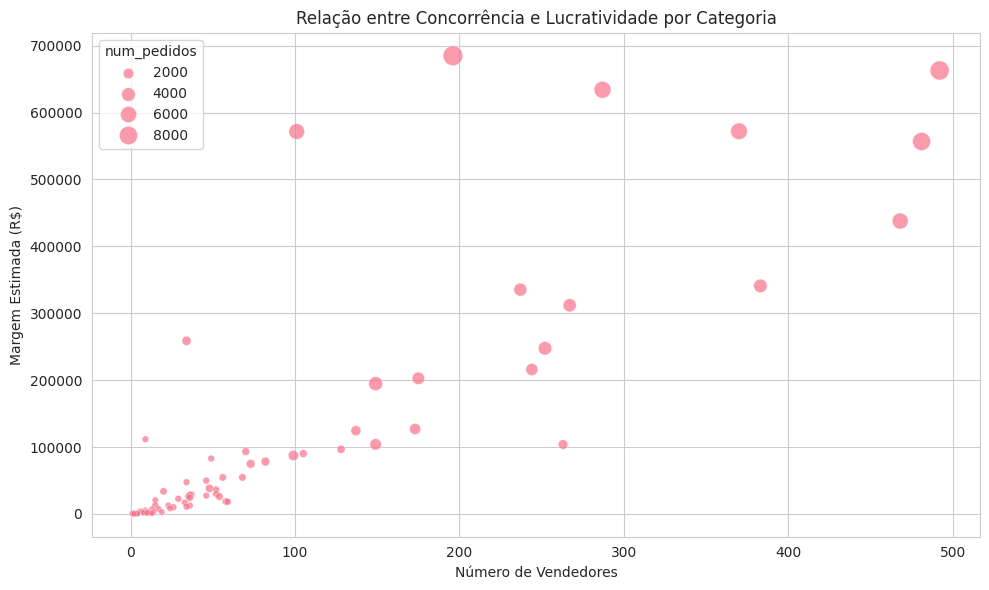

In [74]:
# Estilo
sns.set_palette("husl")

# 1. Gráfico de barras horizontais para lucratividade por categoria (Top 10)
plt.figure(figsize=(12, 6))
top_categorias = rentabilidad_por_categoria.head(10).sort_values('margen_estimado', ascending=True)
plt.barh(top_categorias['product_category_name'], top_categorias['margen_estimado'])
plt.title('Top 10 Categorias por Margem Estimada (40% do valor pago)')
plt.xlabel('Margem Estimada (R$)')
plt.ylabel('Categoria de Produto')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# 2. Relação entre número de vendedores e margem
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rentabilidad_por_categoria,
                x='num_vendedores',
                y='margen_estimado',
                size='num_pedidos',
                sizes=(20, 200),
                alpha=0.7)
plt.title('Relação entre Concorrência e Lucratividade por Categoria')
plt.xlabel('Número de Vendedores')
plt.ylabel('Margem Estimada (R$)')
plt.grid(True)
plt.tight_layout()
plt.show()


- **Alta concorrência = alta margem:** Categorias como bed_bath_table e health_beauty são muito lucrativas, mas com muitos vendedores.

- **Baixa concorrência + baixa margem:** Nichos com poucos vendedores e margem < R$ 100.000 têm potencial de crescimento.

- **Oportunidades:** Algumas categorias com menos de 20 vendedores já superam R$ 100.000 em margem — bons alvos para novos entrantes.

- **Demanda concentrada:** As categorias mais rentáveis também concentram a maioria dos pedidos.

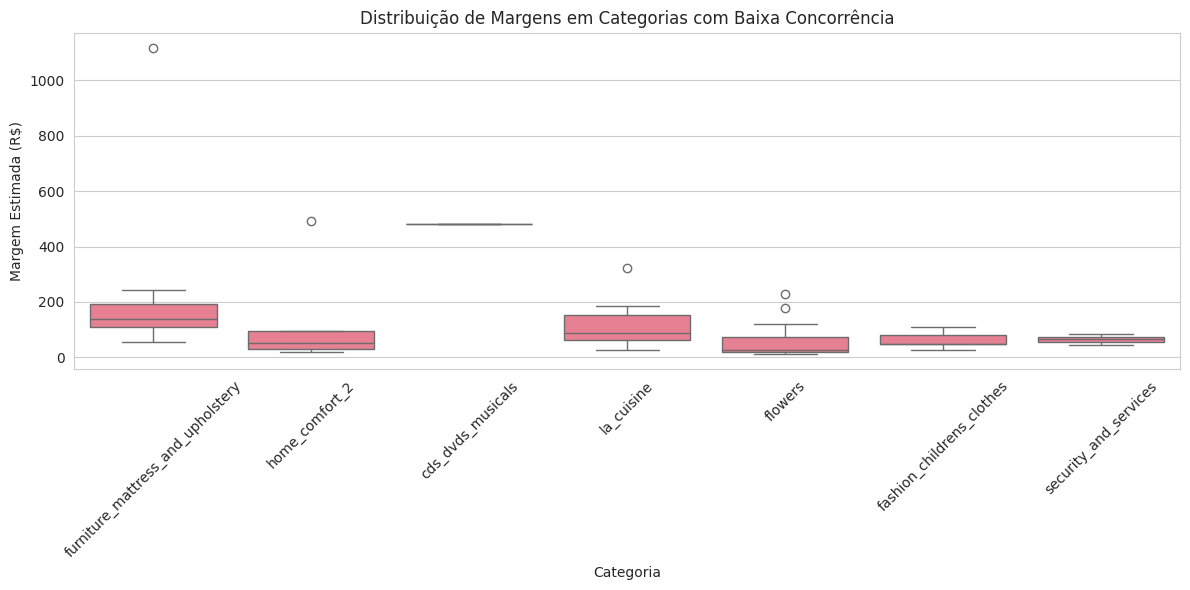

In [75]:
# 1. Distribuição de margens em categorias com baixa concorrência
plt.figure(figsize=(12, 6))
sns.boxplot(data=productos_baja_competencia,
            x='product_category_name',
            y='margen_estimado')
plt.title('Distribuição de Margens em Categorias com Baixa Concorrência')
plt.xlabel('Categoria')
plt.ylabel('Margem Estimada (R$)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- **Alta variabilidade:** algumas categorias, como ``furniture_mattress_and_upholstery e la_cuisine``, têm produtos com margens bem acima da média, indicando oportunidades pontuais lucrativas.

- **Estabilidade da margem:** categorias como ``security_and_services e fashion_childrens_clothes`` apresentam margens mais uniformes, porém baixas.

- **Exceções interessantes:** ``cds_dvds_musicals e home_comfort_2`` têm produtos com margens próximas a R$500 - embora sejam poucos, podem valer a pena.

- **Melhores**: ``furniture_mattress_and_upholstery e la_cuisine`` combinam baixa concorrência com margens médias a altas.

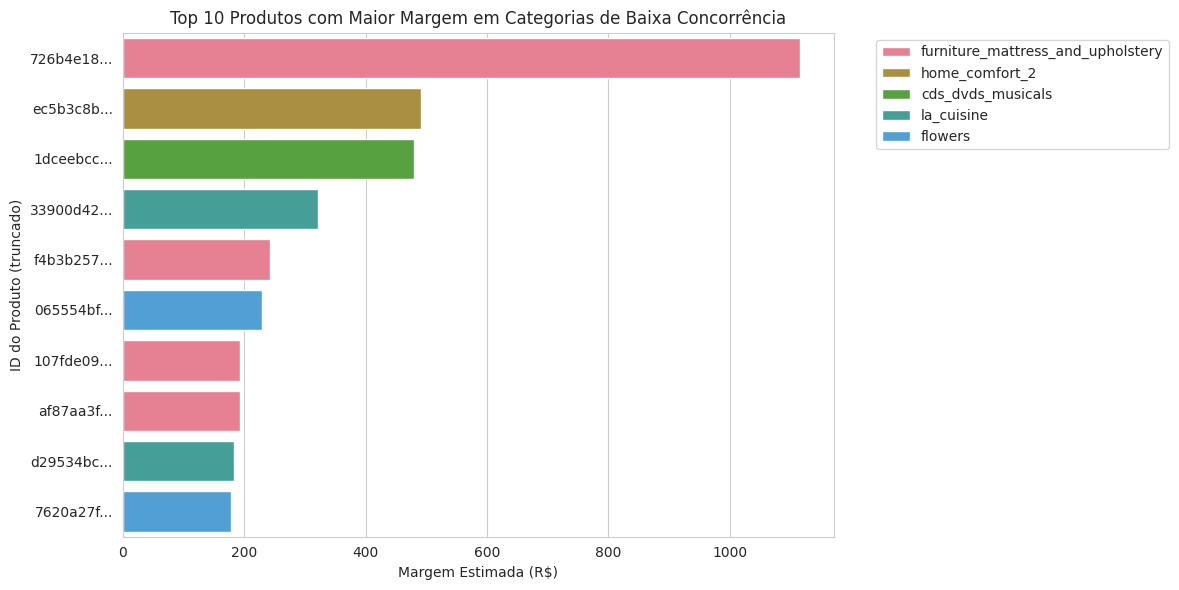

In [76]:
# 2. Top produtos com maior margem em baixa concorrência
top_productos = productos_baja_competencia.sort_values('margen_estimado', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_productos,
            x='margen_estimado',
            y='product_id',
            hue='product_category_name',
            dodge=False)
plt.title('Top 10 Produtos com Maior Margem em Categorias de Baixa Concorrência')
plt.xlabel('Margem Estimada (R$)')
plt.ylabel('ID do Produto (truncado)')
plt.yticks([i for i in range(10)], [pid[:8]+"..." for pid in top_productos['product_id']])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


- Produtos rentáveis em um ambiente de baixa concorrência
``furniture_mattress_and_upholstery``  se destaca com o produto de maior margem (acima de R$ 1.100), mostrando alto potencial em um ambiente de baixa concorrência.

- ``Home_comfort_2, cds_dvds_musicals e la_cuisine`` também se destacam, com margens altas (R$ 400-500), embora com um pouco mais de variabilidade.

- ``flowers``  oferece margens mais moderadas, porém consistentes.

In [77]:
# === Nichos lucrativos ===
drill_across = """
WITH
ventas_por_categoria AS (
    SELECT
        p.product_category_name,
        COUNT(DISTINCT s.seller_id) AS num_vendedores,
        SUM(s.payment_value) * 0.4 AS margen_total,
        COUNT(DISTINCT s.order_id) AS num_pedidos
    FROM fct_sales s
    JOIN dim_product p ON s.product_id = p.product_id
    GROUP BY p.product_category_name
),
satisfaccion_por_categoria AS (
    SELECT
        p.product_category_name,
        AVG(r.review_score) AS avg_score
    FROM fct_reviews r
    JOIN dim_product p ON r.product_id = p.product_id
    GROUP BY p.product_category_name
)
SELECT
    v.product_category_name,
    v.num_vendedores,
    ROUND(v.margen_total, 2) AS margen_total,
    ROUND(v.margen_total / NULLIF(v.num_pedidos, 0), 2) AS margen_por_pedido,
    ROUND(s.avg_score, 2) AS satisfaccion_promedio,
    CASE
        WHEN v.num_vendedores <= 3 AND s.avg_score >= 4.0 THEN 'Nicho Ideal'
        WHEN v.num_vendedores <= 5 AND s.avg_score >= 4.0 THEN 'Nicho Promissor '
        ELSE 'Nicho Regular'
    END AS tipo_nicho
FROM ventas_por_categoria v
JOIN satisfaccion_por_categoria s ON v.product_category_name = s.product_category_name
WHERE v.num_vendedores <= 5
ORDER BY tipo_nicho, margen_total DESC;
"""

nichos_rentables =  pd.read_sql(drill_across, conn)
print("Identificación de Nichos Rentables:")
print(nichos_rentables.head())

Identificación de Nichos Rentables:
               product_category_name  num_vendedores  margen_total  \
0                         la_cuisine               2       1165.41   
1                            flowers               3        885.20   
2                  cds_dvds_musicals               1        479.77   
3  furniture_mattress_and_upholstery               5       2399.42   
4                     home_comfort_2               4        684.22   

   margen_por_pedido  satisfaccion_promedio        tipo_nicho  
0              89.65                   4.55       Nicho Ideal  
1              30.52                   4.50       Nicho Ideal  
2              39.98                   4.67       Nicho Ideal  
3              63.14                   4.21  Nicho Promissor   
4              28.51                   4.22  Nicho Promissor   


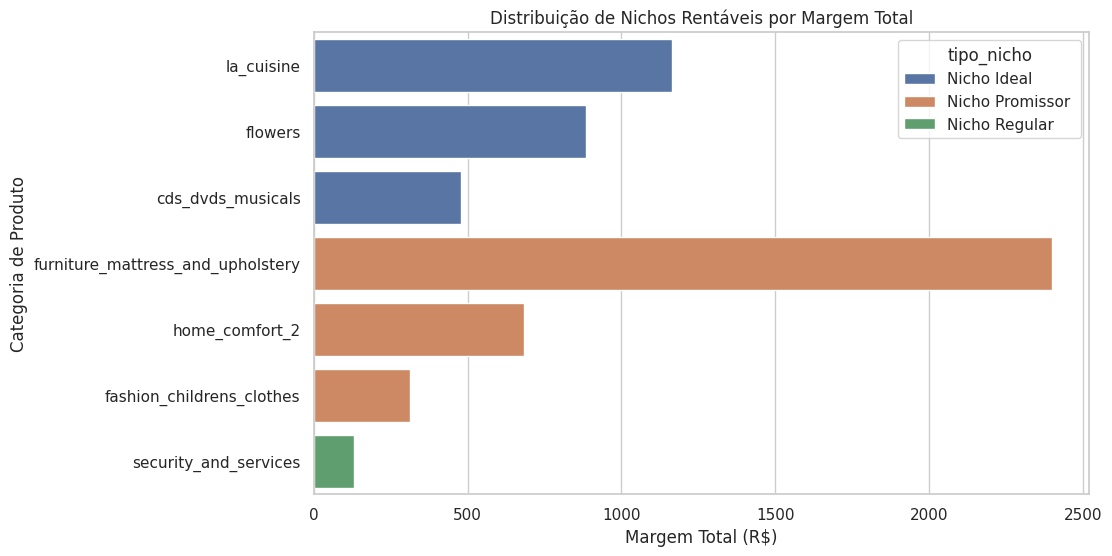

In [78]:
# Estilo
sns.set(style="whitegrid")

# Mapeamento de nichos lucrativos por margem total
plt.figure(figsize=(10, 6))
sns.barplot(x='margen_total', y='product_category_name', data=nichos_rentables, hue='tipo_nicho', dodge=False)
plt.title('Distribuição de Nichos Rentáveis por Margem Total')
plt.xlabel('Margem Total (R$)')
plt.ylabel('Categoria de Produto')
plt.show()


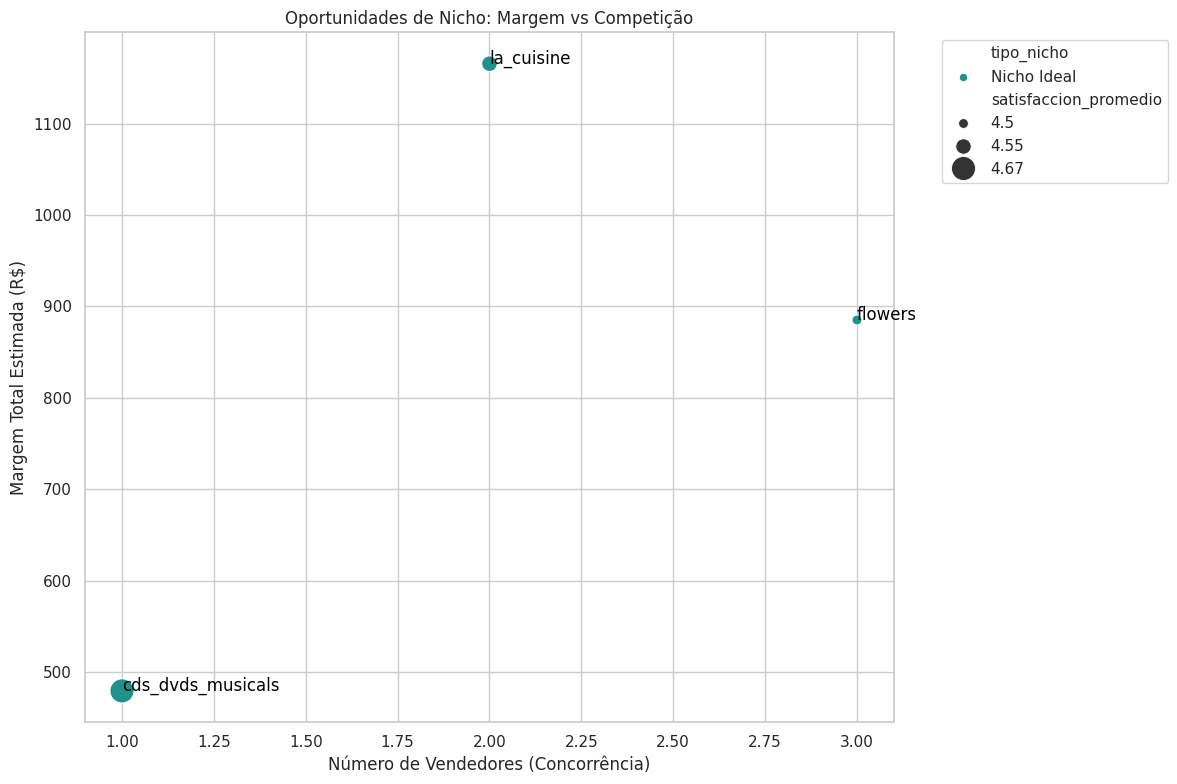

In [79]:
# Filtrar apenas os nichos ideais e promissores
df_nichos_filtrado = nichos_rentables[nichos_rentables['tipo_nicho'].isin(['Nicho Ideal', 'Nicho Prometedor'])]

# Visualização dos nichos com base em margem, competição e satisfação
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=df_nichos_filtrado,
    x='num_vendedores',
    y='margen_total',
    size='satisfaccion_promedio',
    hue='tipo_nicho',
    sizes=(50, 300),
    palette='viridis'
)

plt.title('Oportunidades de Nicho: Margem vs Competição')
plt.xlabel('Número de Vendedores (Concorrência)')
plt.ylabel('Margem Total Estimada (R$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adicionar rótulos às categorias mais relevantes
for line in range(df_nichos_filtrado.shape[0]):
    scatter.text(
        df_nichos_filtrado['num_vendedores'].iloc[line],
        df_nichos_filtrado['margen_total'].iloc[line],
        df_nichos_filtrado['product_category_name'].iloc[line],
        horizontalalignment='left',
        size='medium',
        color='black'
    )

plt.tight_layout()
plt.show()


**Nichos lucrativos e pouco explorados:**

| Categoría           | Vendedores | Margen Total | Satisfacción Prom. |
| ------------------- | ---------- | ------------ | ------------------ |
| la\_cuisine         | 2          | R\$ 1165.41  | 4.08               |
| flowers             | 3          | R\$ 885.20   | 4.48               |
| cds\_dvds\_musicals | 1          | R\$ 479.77   | 4.64               |


**Nichos promissores com margens altas e poca concorrência**

| Categoría                            | Vendedores | Margen Total | Satisfacción Prom. |
| ------------------------------------ | ---------- | ------------ | ------------------ |
| furniture\_mattress\_and\_upholstery | 5          | R\$ 2399.42  | 4.18               |
| home\_comfort\_2                     | 4          | R\$ 684.22   | 4.03               |
| fashion\_childrens\_clothes          | 4          | R\$ 308.63   | 4.00 (aprox)       |


📌**Conclusão**

- ``la_cuisine e flowers`` são nichos prontos para serem explorados com pouco investimento inicial em diferenciação.

- ``furniture_mattress_and_upholstery`` lidera em margem, mas requer estratégia competitiva devido aos seus cinco fornecedores.

- Os principais produtos no gráfico de margem individual também são provenientes dessas mesmas categorias, validando seu potencial.

#### 2. Marketing

In [80]:
# === Lead fechados analisis ===
consulta = """
WITH funnel_base AS (
    SELECT
        dp.lead_origin AS origin,
        ff.business_segment AS product_segment,
        ff.lead_id,
        ff.deal_closed_flag,
        ff.time_to_close
    FROM fct_funnel ff
    LEFT JOIN dim_prospect dp ON ff.lead_id = dp.lead_id
    WHERE ff.qualified_flag = 1
),

funnel_agregado AS (
    SELECT
        origin,
        product_segment,
        COUNT(DISTINCT lead_id) AS leads,
        COUNT(DISTINCT CASE WHEN deal_closed_flag = 1 THEN lead_id END) AS leads_cerrados,
        AVG(time_to_close) AS dias_cierre
    FROM funnel_base
    GROUP BY origin, product_segment

)

SELECT
    origin AS origen_lead,
    product_segment AS categoria_producto,
    leads,
    leads_cerrados,
    ROUND((leads_cerrados * 100.0 / NULLIF(leads, 0)), 2) AS tasa_conversion,
    ROUND(dias_cierre, 2) AS dias_promedio_cierre
FROM funnel_agregado
WHERE leads > 0
ORDER BY origin, tasa_conversion DESC;
"""

consulta_leads=  pd.read_sql(consulta, conn)
print(":")
print(consulta_leads.head())

:
  origen_lead               categoria_producto  leads  leads_cerrados  \
0        None          audio_video_electronics      2               2   
1        None                   bags_backpacks      1               1   
2        None                        computers      1               1   
3        None  construction_tools_house_garden      2               2   
4        None                       food_drink      1               1   

   tasa_conversion  dias_promedio_cierre  
0            100.0                   4.5  
1            100.0                  24.0  
2            100.0                   1.0  
3            100.0                 215.5  
4            100.0                   8.0  


In [81]:
consulta_leads['categoria_producto'].unique()

array(['audio_video_electronics', 'bags_backpacks', 'computers',
       'construction_tools_house_garden', 'food_drink', 'games_consoles',
       'health_beauty', 'home_decor', 'home_office_furniture', 'party',
       None, 'baby', 'bed_bath_table', 'books', 'car_accessories',
       'fashion_accessories', 'food_supplement', 'gifts', 'handcrafted',
       'household_utilities', 'jewerly', 'pet', 'small_appliances',
       'sports_leisure', 'toys', 'stationery', 'air_conditioning',
       'home_appliances', 'music_instruments', 'other', 'perfume',
       'phone_mobile', 'watches', 'religious'], dtype=object)

In [82]:
consulta_leads['origen_lead'].unique()

array([None, 'direct_traffic', 'display', 'email', 'organic_search',
       'other', 'other_publicities', 'paid_search', 'referral', 'social',
       'unknown'], dtype=object)

In [83]:
# Filter out rows where 'origen_lead' is None
consulta_leads= consulta_leads[consulta_leads['origen_lead'].notna() & consulta_leads['categoria_producto'].notna()]
print(consulta_leads.head())

       origen_lead       categoria_producto  leads  leads_cerrados  \
11  direct_traffic  audio_video_electronics      4               4   
12  direct_traffic                     baby      1               1   
13  direct_traffic           bags_backpacks      4               4   
14  direct_traffic           bed_bath_table      1               1   
15  direct_traffic                    books      1               1   

    tasa_conversion  dias_promedio_cierre  
11            100.0                 59.75  
12            100.0                  3.00  
13            100.0                 10.25  
14            100.0                 33.00  
15            100.0                 17.00  


In [84]:
consulta_leads.describe()

,leads,leads_cerrados,tasa_conversion,dias_promedio_cierre
count,168.000000,168.000000,168.0,168.000000
mean,4.916667,4.916667,100.0,48.284226
std,6.212231,6.212231,0.0,52.852523
min,1.000000,1.000000,100.0,1.000000
25%,1.000000,1.000000,100.0,14.000000
50%,2.000000,2.000000,100.0,35.500000
75%,6.000000,6.000000,100.0,60.712500
max,44.000000,44.000000,100.0,306.000000


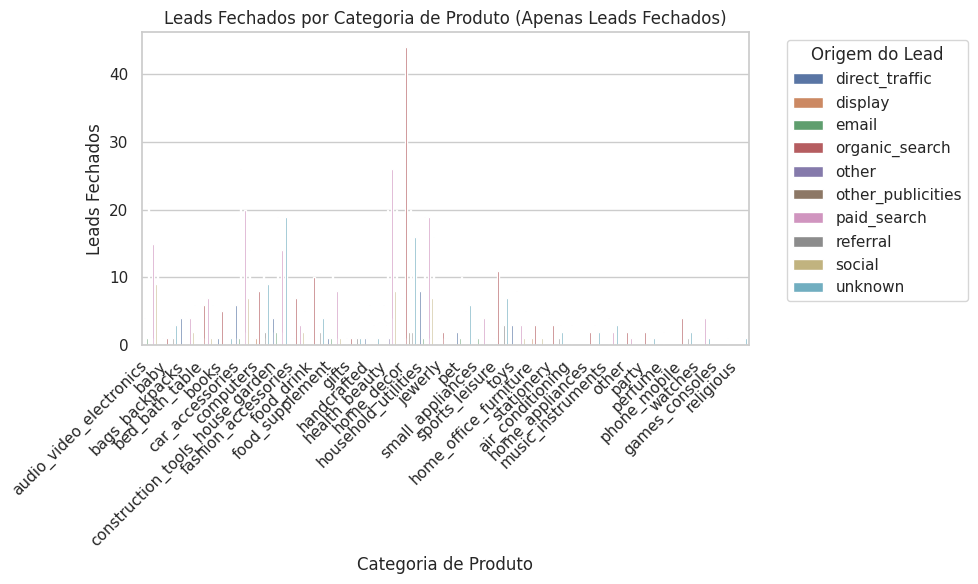

In [85]:
# === Leads Fechados por Categoria de Produto (Apenas Leads Fechados) ===
plt.figure(figsize=(10, 6))

lead_closed_plot = sns.barplot(data=consulta_leads, x='categoria_producto', y='leads_cerrados', hue='origen_lead')
lead_closed_plot.set_title('Leads Fechados por Categoria de Produto (Apenas Leads Fechados)')
lead_closed_plot.set_xlabel('Categoria de Produto')
lead_closed_plot.set_ylabel('Leads Fechados')

plt.xticks(rotation=45, ha="right")
plt.legend(title='Origem do Lead', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Concentração de categorias:**
- algumas categorias, como ``air_conditioning, sports_leisure, housewares e furniture`` mostram um número notável de leads fechados, sugerindo que são mais atraentes para a conversão direta.

**Diversidade de canais:**
- canais como ``direct_traffic, organic_search e paid_search`` aparecem com frequência, mostrando que várias fontes geram resultados em diferentes categorias.

**Canais com bom desempenho geral:**
- ``organic_search e paid_search`` se destacam por volume, indicando um bom direcionamento de SEO/SEM nessas categorias.

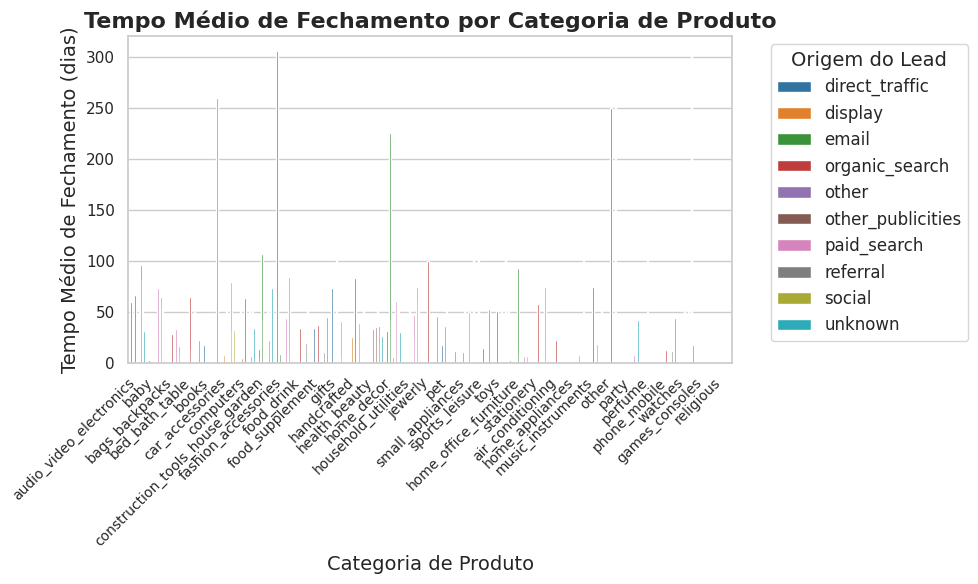

In [86]:
plt.figure(figsize=(10, 6))

# Tempo Médio de Fechamento por Categoria de Produto e Origem do Lead
avg_days_plot = sns.barplot(
    data=consulta_leads,
    x='categoria_producto',
    y='dias_promedio_cierre',
    hue='origen_lead',  # Usamos 'hue' para mostrar as origens dos leads
    palette='tab10'  # Alterar a paleta de cores
)

# Titulos
avg_days_plot.set_title('Tempo Médio de Fechamento por Categoria de Produto', fontsize=16, fontweight='bold')
avg_days_plot.set_xlabel('Categoria de Produto', fontsize=14)
avg_days_plot.set_ylabel('Tempo Médio de Fechamento (dias)', fontsize=14)

# Legenda e Layout
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.legend(title='Origem do Lead', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()


**Alta variabilidade:**
- O tempo de fechamento varia muito entre as categorias. Algumas, como ``computers  e food_drink`` , fecham em poucos dias, enquanto outras, como ``housewares o construction_tools`` , levam mais de 200 dias.

**Canais mais rápidos:**
- O canal de ``e-mail`` tende a ser associado a fechamentos mais rápidos, assim como o ``direct_traffic``, o que pode indicar um lead “mais quente” ou mais informado desde o início.

**Canais mais lentos:**
- Display e referral estão associados a tempos mais longos em determinadas categorias, o que pode indicar leads menos qualificados ou processos de decisão mais longos.

**Ranking categoria + fonte de leads**
- O código a seguir tem como objetivo calcular uma classificação das melhores combinações de categoria + fonte de leads, usando uma pontuação composta que leva em conta três fatores principais: conversão, volume e velocidade de fechamento.

In [87]:
from sklearn.preprocessing import MinMaxScaler
# === Principais categorias de liderança (melhor desempenho geral) ===
# Cópia do dataframe
ranking_df = consulta_leads.copy()

# Inverter 'dias_promedio_cierre' porque menos dias para o cerre do lead é melhor (maior conversão)
ranking_df['dias_inverso'] = ranking_df['dias_promedio_cierre'].max() - ranking_df['dias_promedio_cierre']

# Escalonar os dados para o intervalo de 0 a 1
scaler = MinMaxScaler()
ranking_df[['score_conversion', 'score_leads_cerrados', 'score_cierre_rapido']] = scaler.fit_transform(
    ranking_df[['tasa_conversion', 'leads_cerrados', 'dias_inverso']]
)

# Cálculo do score total (os pesos podem ser ajustados conforme a prioridade)
ranking_df['score_total'] = (
    ranking_df['score_conversion'] * 0.4 +
    ranking_df['score_leads_cerrados'] * 0.4 +
    ranking_df['score_cierre_rapido'] * 0.2
)

# Top 10 categorias com melhor desempenho geral
top_categorias = ranking_df.sort_values('score_total', ascending=False).head(10)
print(top_categorias[['categoria_producto', 'origen_lead', 'tasa_conversion', 'leads_cerrados', 'dias_promedio_cierre', 'score_total']])



                  categoria_producto     origen_lead  tasa_conversion  \
68                        home_decor  organic_search            100.0   
105                    health_beauty     paid_search            100.0   
58                   car_accessories  organic_search            100.0   
172                    health_beauty         unknown            100.0   
66                     health_beauty  organic_search            100.0   
53           audio_video_electronics  organic_search            100.0   
60   construction_tools_house_garden  organic_search            100.0   
107                       home_decor     paid_search            100.0   
109              household_utilities     paid_search            100.0   
70               household_utilities  organic_search            100.0   

     leads_cerrados  dias_promedio_cierre  score_total  
68               44                 42.86     0.572551  
105              26                 53.08     0.398407  
58               26      

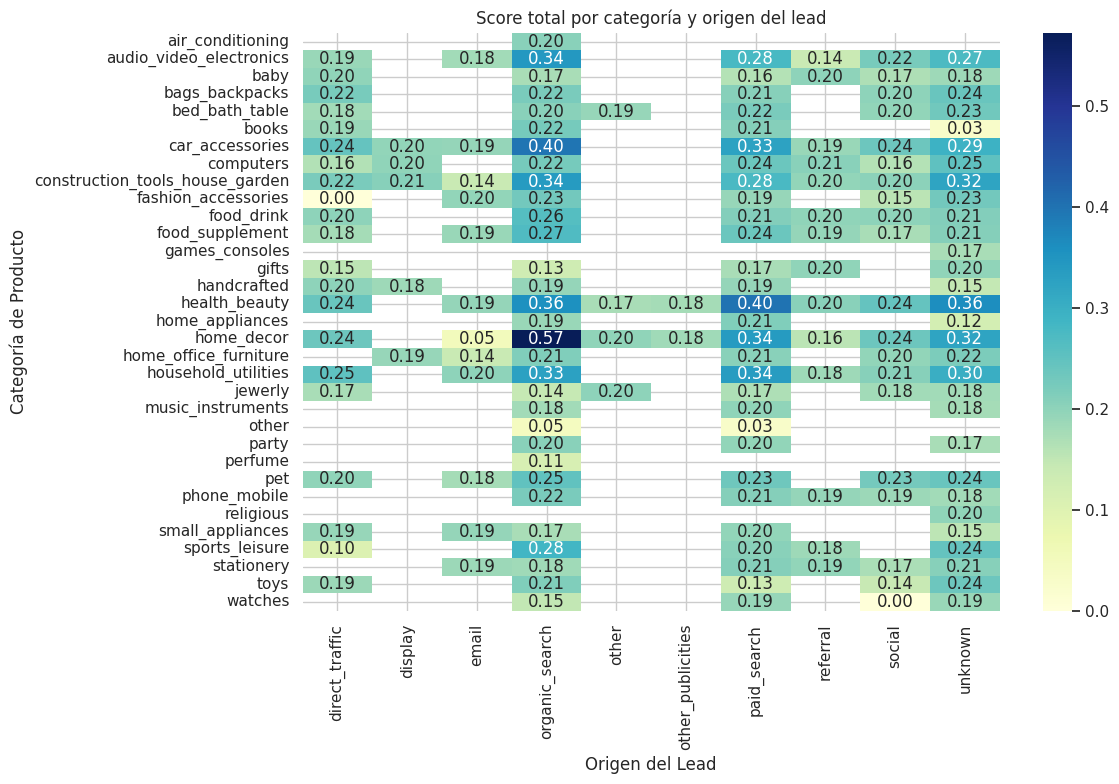

In [88]:
# Heatmap todas categorias
pivot = ranking_df.pivot_table(
    index='categoria_producto',
    columns='origen_lead',
    values='score_total'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Score total por categoría y origen del lead")
plt.xlabel("Origen del Lead")
plt.ylabel("Categoría de Producto")
plt.tight_layout()
plt.show()


- Esse mapa de calor cruza categorias de produtos (linhas) com origens de leads (colunas) e exibe um valor numérico (pontuação total) codificado por cor. Quanto mais escura (azul escuro) for a cor, melhor será o desempenho dessa combinação.

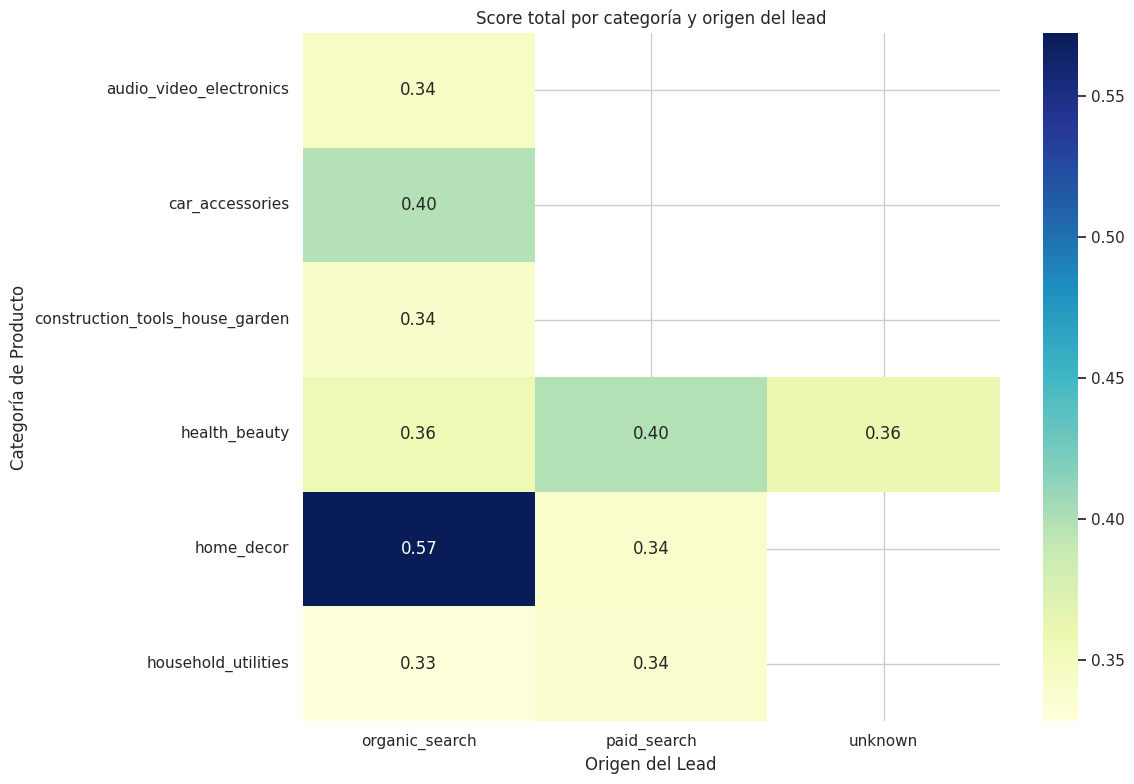

In [89]:
# Heatmap so top categorias
pivot = top_categorias.pivot_table(
    index='categoria_producto',
    columns='origen_lead',
    values='score_total'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Score total por categoría y origen del lead")
plt.xlabel("Origen del Lead")
plt.ylabel("Categoría de Producto")
plt.tight_layout()
plt.show()


##### **Conclusão de Rankings**

**Canais dominantes:**
- ``organic_search e paid_serch`` mostran várias combinações com pontuações altas, indicando que são canais muito eficazes em várias categorias.

**Categorias com desempenho consistente:**

- ``car_accessories, health_beauty, household_utilities, construction_tools_house_garden`` mostram pontuações altas em vários canais → candidatos a escalonamento.
- ``home_decor`` tem um desempenho excepcionalmente bom com orgânicos, mas ruim com outros canais → muito dependente de uma única fonte.

**Oportunidades para melhorar ou evitar:**
- Categorias como ``fashion_accessories, books, jewellery e party`` têm pontuações muito baixas ou ausentes → baixa conversão ou volume.

- Canais como ``display e e-mail`` raramente aparecem com valores altos → possível baixa eficácia nesse contexto.

#### 3. Clientes, Nichos y Marketing Reviews

In [90]:
consulta = """
WITH business_to_nicho AS (
    SELECT 'food_drink' AS business_segment, 'la_cuisine' AS nicho_rentable
    UNION ALL SELECT 'home_decor', 'flowers'
    UNION ALL SELECT 'music_instruments', 'cds_dvds_musicals'
    UNION ALL SELECT 'home_appliances', 'furniture_mattress_and_upholstery'
    UNION ALL SELECT 'home_decor', 'home_comfort_2'
    UNION ALL SELECT 'baby', 'fashion_childrens_clothes'
),

nichos_marketing AS (
    SELECT
        dp.lead_origin,
        b2n.nicho_rentable,
        ff.lead_id,
        ff.deal_closed_flag,
        ff.time_to_close
    FROM fct_funnel ff
    JOIN dim_prospect dp ON ff.lead_id = dp.lead_id
    JOIN business_to_nicho b2n ON ff.business_segment = b2n.business_segment
),

reviews_nicho AS (
    SELECT
        b2n.nicho_rentable,
        ROUND(AVG(fr.review_score), 2) AS avg_review_score,
        COUNT(fr.review_id) AS total_reviews
    FROM fct_reviews fr
    JOIN dim_product dp ON fr.product_id = dp.product_id
    JOIN business_to_nicho b2n ON dp.product_category_name = b2n.business_segment
    GROUP BY b2n.nicho_rentable
)

SELECT
    nm.lead_origin,
    nm.nicho_rentable,
    COUNT(DISTINCT CASE WHEN nm.deal_closed_flag = 1 THEN nm.lead_id END) AS leads_cerrados,
    ROUND(AVG(CASE WHEN nm.deal_closed_flag = 1 THEN nm.time_to_close END), 2) AS dias_cierre,
    rn.avg_review_score,
    rn.total_reviews
FROM nichos_marketing nm
LEFT JOIN reviews_nicho rn ON nm.nicho_rentable = rn.nicho_rentable

GROUP BY nm.lead_origin, nm.nicho_rentable, rn.avg_review_score, rn.total_reviews
ORDER BY dias_cierre DESC;


"""

consulta_clientes =  pd.read_sql(consulta, conn)
print(":")
print(consulta_clientes.head())

:
  lead_origin                     nicho_rentable  leads_cerrados  dias_cierre  \
0       email                            flowers               1       226.00   
1       email                     home_comfort_2               1       226.00   
2     unknown  furniture_mattress_and_upholstery               2       133.50   
3      social                            flowers              11        89.09   
4      social                     home_comfort_2              11        89.09   

   avg_review_score  total_reviews  
0               NaN            NaN  
1               NaN            NaN  
2               4.3          667.0  
3               NaN            NaN  
4               NaN            NaN  


In [91]:
consulta_clientes.describe()

,leads_cerrados,dias_cierre,avg_review_score,total_reviews
count,39.000000,39.000000,16.000000,16.000000
mean,6.717949,49.876154,4.405000,1141.687500
std,10.269907,51.656852,0.122963,1084.935926
min,1.000000,1.000000,4.300000,198.000000
25%,1.000000,14.835000,4.300000,198.000000
50%,2.000000,41.000000,4.300000,667.000000
75%,7.000000,63.500000,4.540000,2480.000000
max,44.000000,226.000000,4.540000,2480.000000


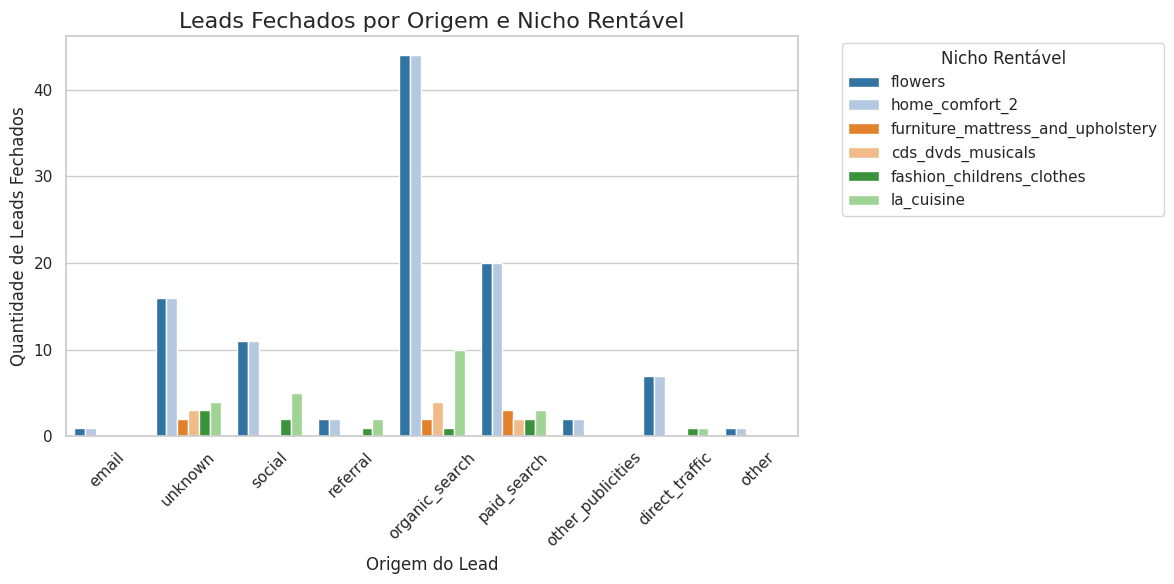

In [92]:
# Gráfico de barras para mostrar os leads fechados por origem e nicho rentável
plt.figure(figsize=(12, 6))
sns.barplot(
    x='lead_origin',
    y='leads_cerrados',
    hue='nicho_rentable',
    data=consulta_clientes,
    palette='tab20'
)

# Plot
plt.title('Leads Fechados por Origem e Nicho Rentável', fontsize=16)
plt.xlabel('Origem do Lead', fontsize=12)
plt.ylabel('Quantidade de Leads Fechados', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Nicho Rentável', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


- A maioria dos leads fechados vem de ornaic_seach , seguido por paid_search, com destaque para os nichos flowers e home_comfort_2. Estes nichos dominam quase todas as origens. Ele se encaixa nos resultados gerais do mapa de calor.

<ipython-input-93-05a48f2ac32d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


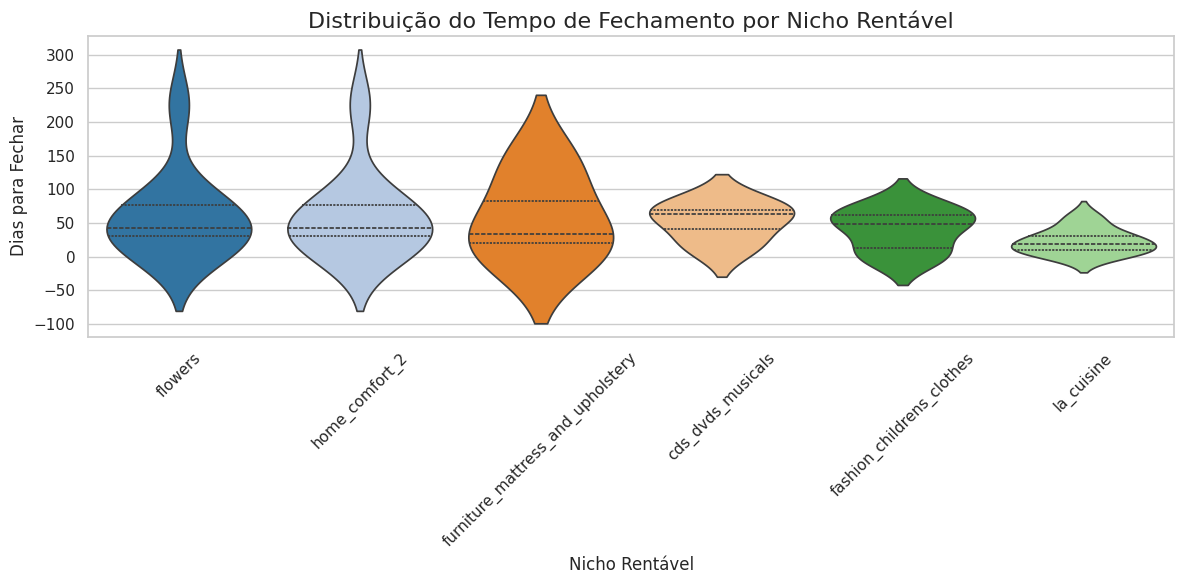

In [93]:
# Gráfico de violino para mostrar a distribuição do tempo de fechamento por nicho rentável
plt.figure(figsize=(12, 6))
sns.violinplot(
    x='nicho_rentable',
    y='dias_cierre',
    data=consulta_clientes,
    palette='tab20',
    inner="quart"
)

# Plot
plt.title('Distribuição do Tempo de Fechamento por Nicho Rentável', fontsize=16)
plt.xlabel('Nicho Rentável', fontsize=12)
plt.ylabel('Dias para Fechar', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- Nicho ``la_cuisine`` é o mais rápido para fechar leads, enquanto ``furniture_mattress_and_upholstery`` mostra maior variabilidade e tempo de fechamento. ``flowers`` e ``home_comfort_2`` têm tempos medianos moderados, com alguns outliers.

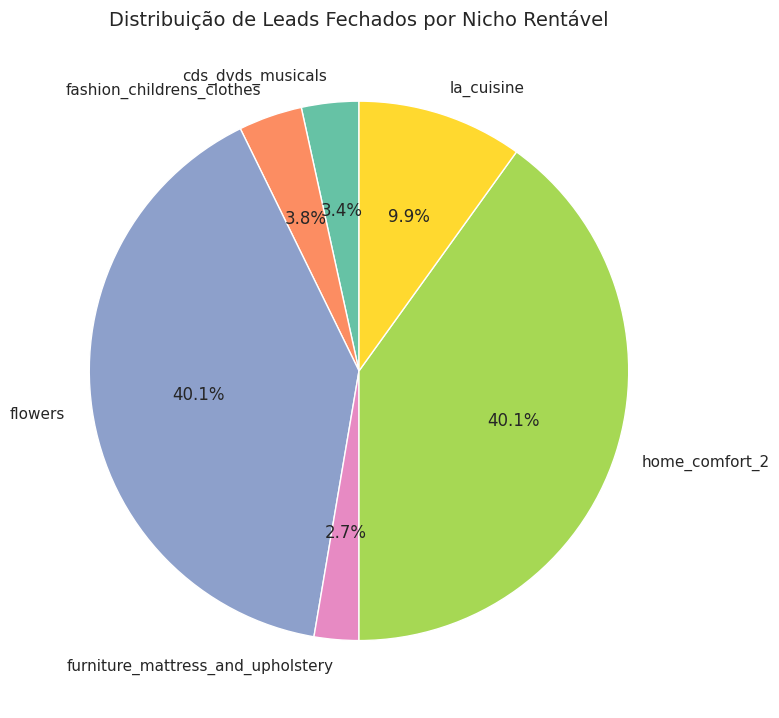

In [94]:
# Agrupar os dados para obter a distribuição de leads fechados por nicho rentável
leads_por_nicho = consulta_clientes.groupby('nicho_rentable')['leads_cerrados'].sum()

# Pie Plot
plt.figure(figsize=(8, 8))
plt.pie(
    leads_por_nicho,
    labels=leads_por_nicho.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Set2', len(leads_por_nicho))
)

# Plot
plt.title('Distribuição de Leads Fechados por Nicho Rentável', fontsize=14)
plt.tight_layout()
plt.show()



- ``flowers e home_comfort_2`` representam mais de 80% dos leads fechados, indicando altíssima concentração de performance nesses dois nichos. Os demais têm participação muito menor.

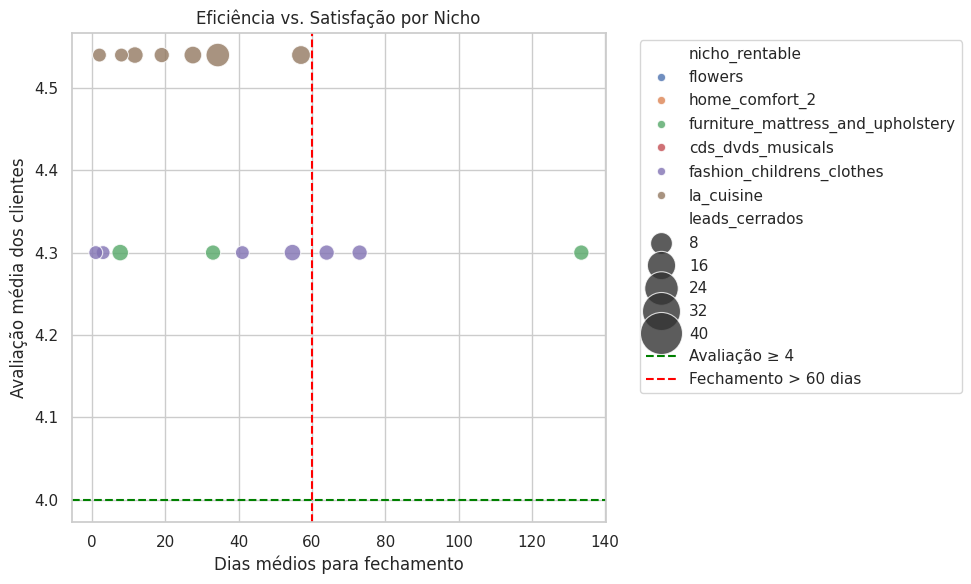

In [95]:
# Eficiência vs. Satisfação por Nicho
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=consulta_clientes,
    x="dias_cierre",
    y="avg_review_score",
    size="leads_cerrados",
    hue="nicho_rentable",
    sizes=(100, 1000),
    alpha=0.8
)
plt.axhline(4, ls='--', color='green', label='Avaliação ≥ 4')
plt.axvline(60, ls='--', color='red', label='Fechamento > 60 dias')
plt.title("Eficiência vs. Satisfação por Nicho")
plt.xlabel("Dias médios para fechamento")
plt.ylabel("Avaliação média dos clientes")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


- Todos os nichos mantêm uma avaliação média ≥ 4. ``la_cuisine`` se destaca com alta avaliação e baixo tempo de fechamento. ``furniture_mattress_and_upholstery`` apresenta um tempo médio muito elevado (>130 dias), afetando sua eficiência.

###### **Conclusão**
Os nichos ``flowers e home_comfort_2`` são líderes absolutos em volume de leads fechados, mas ``la_cuisine`` mostra um equilíbrio ideal entre eficiência e satisfação. Investir mais em nichos rápidos e bem avaliados pode gerar ganhos consistentes com menos esforço operacional.